# Imports

In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from scipy.stats import entropy, wasserstein_distance, ks_2samp
import pandas as pd
import json
from ollama import generate
import re

## Fixing Target values

In [86]:
# Combine features and target into a single DataFrame
df = pd.read_csv('data.csv', delimiter=';')

# Encode target variable
mapping = {'Graduate': 0, 'Dropout': 1, 'Enrolled': 2}
df['Target_encoded'] = df['Target'].map(mapping)

In [87]:
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Target_encoded
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
1,1,15,1,9254,1,1,160.0,1,1,3,...,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate,0
2,1,1,5,9070,1,1,122.0,1,37,37,...,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
3,1,17,2,9773,1,1,122.0,1,38,37,...,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate,0
4,2,39,1,8014,0,1,100.0,1,37,38,...,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate,0
4420,1,1,2,9773,1,1,120.0,105,1,1,...,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout,1
4421,1,1,1,9500,1,1,154.0,1,37,37,...,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout,1
4422,1,1,1,9147,1,1,180.0,1,37,37,...,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate,0


## Train-test spliting for original dataset

In [88]:
# Drop the original target column
df = df.drop('Target', axis=1)

# Split the data into features and target
X = df.drop(columns=['Target_encoded'])
y = df['Target_encoded']

# Split the data into training and testing sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=17)

# Basic and Advanced params for models

In [89]:
# Define common parameters for models
common_params = {
    'max_depth': 9,
    'learning_rate': 0.01,
    'n_estimators': 200
}

In [90]:

catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 8,
    'l2_leaf_reg': 3,
    'border_count': 128,
    'verbose': 0
}

# XGBoost-specific parameters
xgboost_params = {
    'n_estimators': 500,
    'learning_rate': 0.01,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# Random Forest-specific parameters
randomforest_params = {
    'n_estimators': 500,
    'max_depth': 12,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'oob_score': True
}

# Models with basic params and advanced ones

In [91]:
# Define models
models = {
    'CatBoost': CatBoostClassifier(verbose=0, random_state=17),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=17),
    'RandomForest': RandomForestClassifier(random_state=17)
}

In [92]:
better_models = {
    'CatBoost': CatBoostClassifier(random_state=17, **catboost_params),
    'XGBoost': XGBClassifier(random_state=17, **xgboost_params),
    'RandomForest': RandomForestClassifier(random_state=17, **randomforest_params)
}

# Evaluating model function

In [93]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred_proba': y_pred_proba
    }

In [94]:
# Evaluate models on full dataset
results_full = {}
for model_name, model in models.items():
    print(f"Training {model_name} on full dataset...")
    results_full[model_name] = evaluate_model(model, X_train_full, y_train_full, X_test_full, y_test_full)

Training CatBoost on full dataset...
Training XGBoost on full dataset...
Training RandomForest on full dataset...


E:\Research\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:50:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Plotting results for Original Dataset
## *Basic params*

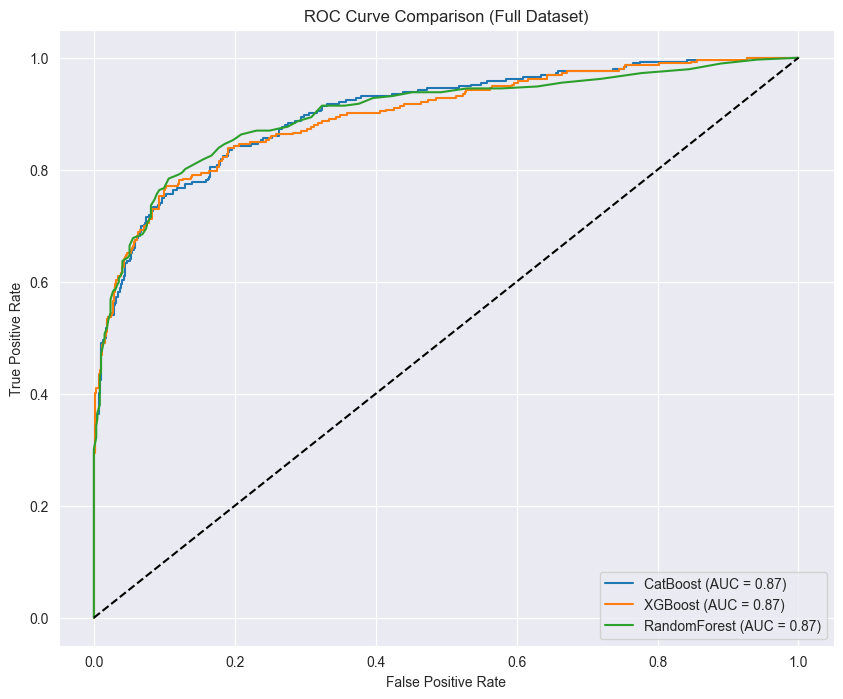

In [95]:
# Plot ROC curves for full dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_full.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Full Dataset)')
plt.legend(loc='lower right')
plt.show()

In [96]:
results_full_better = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} on full dataset...")
    results_full_better[better_model_name] = evaluate_model(better_model, X_train_full, y_train_full, X_test_full, y_test_full)

Training CatBoost on full dataset...
Training XGBoost on full dataset...


E:\Research\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:51:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest on full dataset...


## *Advanced params*

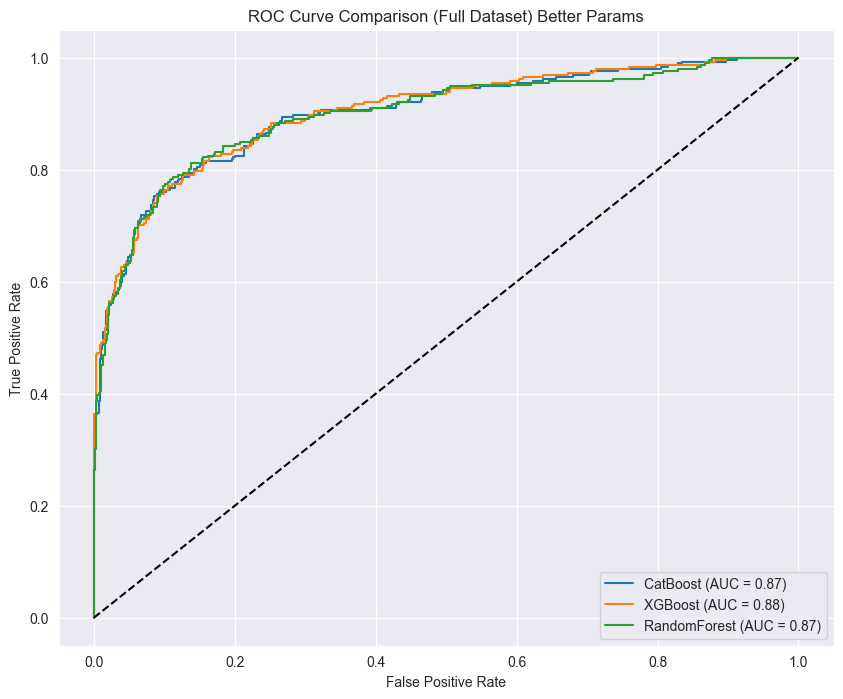

In [97]:
# Plot ROC curves for full dataset
plt.figure(figsize=(10, 8))
for better_model_name, better_result in results_full_better.items():
    fpr, tpr, _ = roc_curve(y_test_full, better_result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{better_model_name} (AUC = {better_result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Full Dataset) Better Params')
plt.legend(loc='lower right')
plt.show()

In [98]:
# Print results for full dataset
for model_name, result in results_full.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.7503
Precision: 0.7419
Recall: 0.7503
F1-Score: 0.7441
ROC-AUC: 0.8726

Model: XGBoost
Accuracy: 0.7469
Precision: 0.7400
Recall: 0.7469
F1-Score: 0.7407
ROC-AUC: 0.8713

Model: RandomForest
Accuracy: 0.7729
Precision: 0.7652
Recall: 0.7729
F1-Score: 0.7631
ROC-AUC: 0.8745


In [99]:
for better_model_name, better_result in results_full_better.items():
    print(f"\nModel: {better_model_name}")
    print(f"Accuracy: {better_result['accuracy']:.4f}")
    print(f"Precision: {better_result['precision']:.4f}")
    print(f"Recall: {better_result['recall']:.4f}")
    print(f"F1-Score: {better_result['f1']:.4f}")
    print(f"ROC-AUC: {better_result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.7661
Precision: 0.7519
Recall: 0.7661
F1-Score: 0.7540
ROC-AUC: 0.8715

Model: XGBoost
Accuracy: 0.7638
Precision: 0.7539
Recall: 0.7638
F1-Score: 0.7542
ROC-AUC: 0.8780

Model: RandomForest
Accuracy: 0.7650
Precision: 0.7507
Recall: 0.7650
F1-Score: 0.7509
ROC-AUC: 0.8702


# Making sliced dataset

In [100]:
# Slice the dataset
df_sliced = df.sample(frac=0.1, random_state=17)
X_sliced = df_sliced.drop('Target_encoded', axis=1)
y_sliced = df_sliced['Target_encoded']

In [101]:
# Split the sliced data into training and testing sets
X_train_sliced, X_test_sliced, y_train_sliced, y_test_sliced = train_test_split(X_sliced, y_sliced, test_size=0.2, random_state=17)

In [102]:
# Evaluate models on sliced dataset
results_sliced = {}
for model_name, model in models.items():
    print(f"Training {model_name} on sliced dataset...")
    results_sliced[model_name] = evaluate_model(model, X_train_sliced, y_train_sliced, X_test_full, y_test_full)

Training CatBoost on sliced dataset...
Training XGBoost on sliced dataset...
Training RandomForest on sliced dataset...


E:\Research\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:51:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [103]:
better_results_sliced = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} on sliced dataset...")
    better_results_sliced[better_model_name] = evaluate_model(better_model, X_train_sliced, y_train_sliced, X_test_full, y_test_full)

Training CatBoost on sliced dataset...
Training XGBoost on sliced dataset...


E:\Research\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:51:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest on sliced dataset...


# *Slicecd Dataset*
## *Basic params*

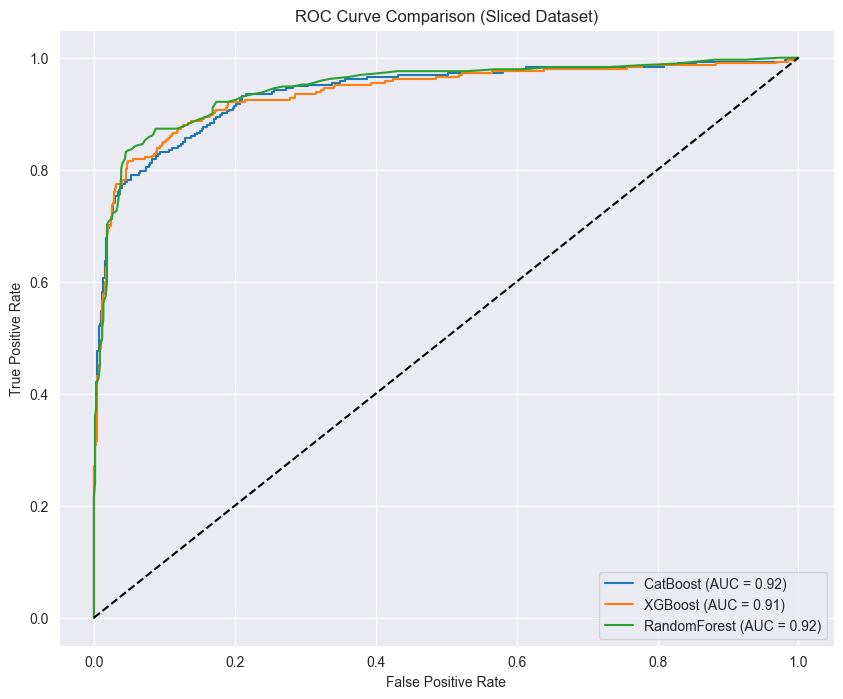

In [104]:
# Plot ROC curves for sliced dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_sliced.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Sliced Dataset)')
plt.legend(loc='lower right')
plt.show()

## *Advanced params*

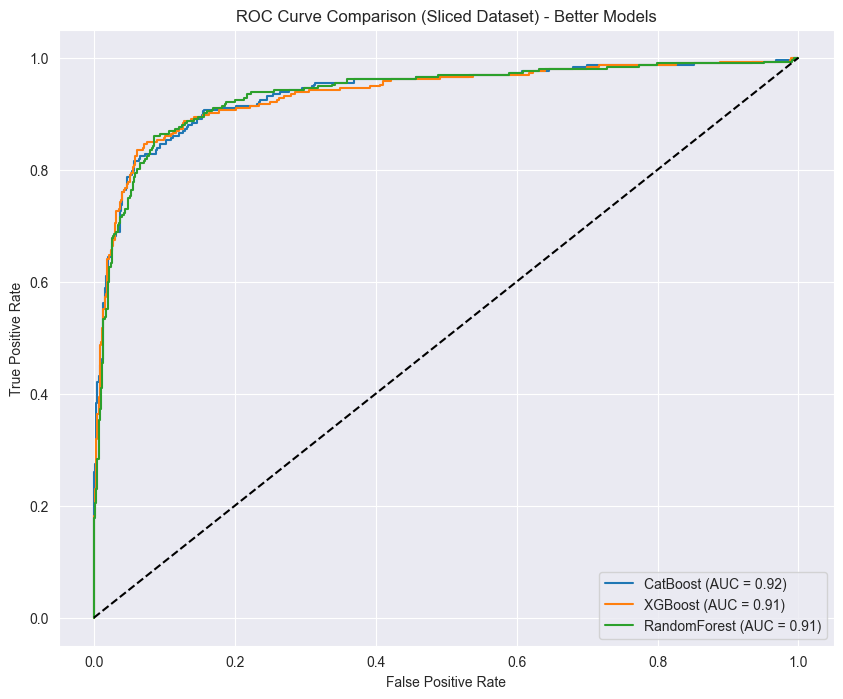

In [105]:
plt.figure(figsize=(10, 8))
for better_model_name, better_result in better_results_sliced.items():
    fpr, tpr, _ = roc_curve(y_test_full, better_result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{better_model_name} (AUC = {better_result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Sliced Dataset) - Better Models')
plt.legend(loc='lower right')
plt.show()

In [106]:
# Print results for sliced dataset
for model_name, result in results_sliced.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.8192
Precision: 0.8154
Recall: 0.8192
F1-Score: 0.8117
ROC-AUC: 0.9206

Model: XGBoost
Accuracy: 0.8249
Precision: 0.8195
Recall: 0.8249
F1-Score: 0.8204
ROC-AUC: 0.9149

Model: RandomForest
Accuracy: 0.8328
Precision: 0.8295
Recall: 0.8328
F1-Score: 0.8237
ROC-AUC: 0.9248


In [107]:
# Print results for sliced dataset
for better_model_name, better_result in better_results_sliced.items():
    print(f"\nModel: {better_model_name}")
    print(f"Accuracy: {better_result['accuracy']:.4f}")
    print(f"Precision: {better_result['precision']:.4f}")
    print(f"Recall: {better_result['recall']:.4f}")
    print(f"F1-Score: {better_result['f1']:.4f}")
    print(f"ROC-AUC: {better_result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.8237
Precision: 0.8285
Recall: 0.8237
F1-Score: 0.8109
ROC-AUC: 0.9176

Model: XGBoost
Accuracy: 0.8271
Precision: 0.8225
Recall: 0.8271
F1-Score: 0.8190
ROC-AUC: 0.9103

Model: RandomForest
Accuracy: 0.8226
Precision: 0.8232
Recall: 0.8226
F1-Score: 0.8090
ROC-AUC: 0.9131


# Saving sliced dataset

In [108]:
# Save the sliced dataset to a CSV file
df_sliced.to_csv('E:/Research/df_sliced.csv', index=False)

# Chat-GPT generated dataset

In [109]:
# Load the synthetic dataset generated by GPT
df_gpt = pd.read_csv('E:/Research/synthetic_dataset.csv')

In [110]:
# Evaluate models on GPT-generated dataset
results_gpt = {}
for model_name, model in models.items():
    print(f"Training {model_name} on GPT-generated dataset...")
    results_gpt[model_name] = evaluate_model(model, X_train_full, y_train_full, X_test_full, y_test_full)

Training CatBoost on GPT-generated dataset...
Training XGBoost on GPT-generated dataset...
Training RandomForest on GPT-generated dataset...


E:\Research\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:52:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# *GPT-dataset basic params*

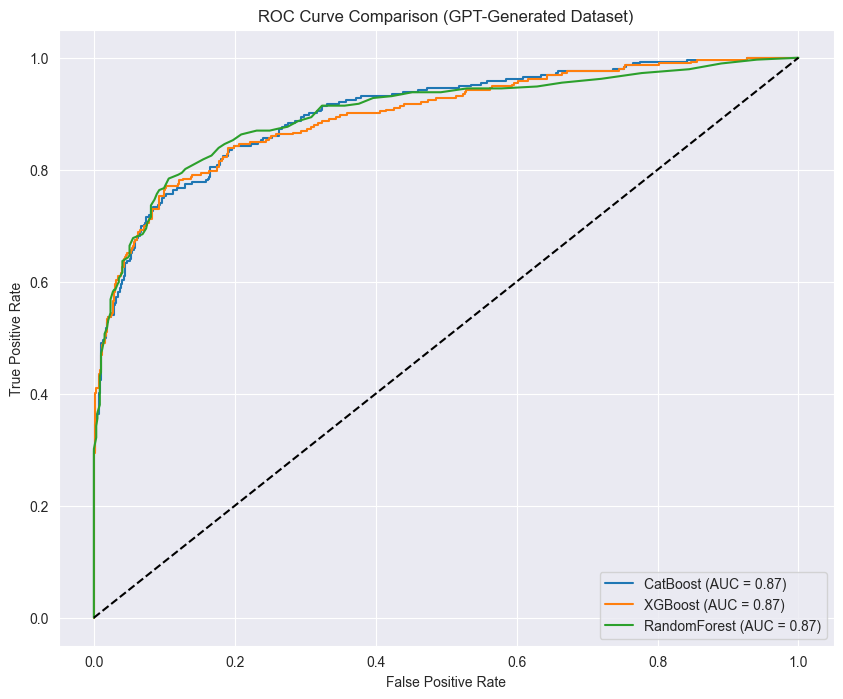

In [111]:
# Plot ROC curves for GPT-generated dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_gpt.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (GPT-Generated Dataset)')
plt.legend(loc='lower right')
plt.show()

In [112]:
# Print results for GPT-generated dataset
for model_name, result in results_gpt.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.7503
Precision: 0.7419
Recall: 0.7503
F1-Score: 0.7441
ROC-AUC: 0.8726

Model: XGBoost
Accuracy: 0.7469
Precision: 0.7400
Recall: 0.7469
F1-Score: 0.7407
ROC-AUC: 0.8713

Model: RandomForest
Accuracy: 0.7729
Precision: 0.7652
Recall: 0.7729
F1-Score: 0.7631
ROC-AUC: 0.8745


## *Deepseek function for generation samples*

In [113]:
# Function to generate a new dataset using resampling (Deepseek)
def generate_new_dataset(original_df, multiplier=10):
    new_data = []
    for _ in range(multiplier):
        resampled_df = resample(original_df, replace=True, n_samples=len(original_df), random_state=np.random.randint(0, 100))
        new_data.append(resampled_df)
    return pd.concat(new_data, ignore_index=True)

## *Copilot function for generation samples (with the second prompt)*

In [114]:
# Function to generate synthetic data (Copilot)
def generate_synthetic_data(data, size_multiplier=10):
    synthetic_data = pd.DataFrame()
    for col in data.columns:
        if col == "Target_encoded":
            synthetic_data[col] = np.random.choice([0, 1, 2], len(data) * size_multiplier)
        elif data[col].dtype in [np.float64, np.int64]:
            synthetic_data[col] = np.random.normal(data[col].mean(), data[col].std(), len(data) * size_multiplier)
        else:
            synthetic_data[col] = np.random.choice(data[col], len(data) * size_multiplier)
    return synthetic_data


In [115]:
# Load the sliced dataset
df_sliced = pd.read_csv('df_sliced.csv')

# Generate deepseek dataset using resampling
df_deepseek = generate_new_dataset(df_sliced, multiplier=10)

# Generate copilot dataset using synthetic data generation
df_copilot = generate_synthetic_data(df_sliced)

## *Dataset preparation*

In [116]:

# Prepare datasets for training and testing
def prepare_datasets(df):
    X = df.drop('Target_encoded', axis=1)
    y = df['Target_encoded']
    return train_test_split(X, y, test_size=0.2, random_state=17)


In [117]:
X_train_deepseek, X_test_deepseek, y_train_deepseek, y_test_deepseek = prepare_datasets(df_deepseek)
X_train_copilot, X_test_copilot, y_train_copilot, y_test_copilot = prepare_datasets(df_copilot)

In [118]:
# Evaluate models on deepseek dataset
results_deepseek = {}
for model_name, model in models.items():
    print(f"Training {model_name} on deepseek dataset...")
    results_deepseek[model_name] = evaluate_model(model, X_train_deepseek, y_train_deepseek, X_test_full, y_test_full)

Training CatBoost on deepseek dataset...
Training XGBoost on deepseek dataset...
Training RandomForest on deepseek dataset...


E:\Research\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:52:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [119]:
# Evaluate models on copilot dataset
results_copilot = {}
for model_name, model in models.items():
    print(f"Training {model_name} on copilot dataset...")
    results_copilot[model_name] = evaluate_model(model, X_train_copilot, y_train_copilot, X_test_full, y_test_full)

Training CatBoost on copilot dataset...
Training XGBoost on copilot dataset...


E:\Research\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:52:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest on copilot dataset...


# Deepseek result with basic params

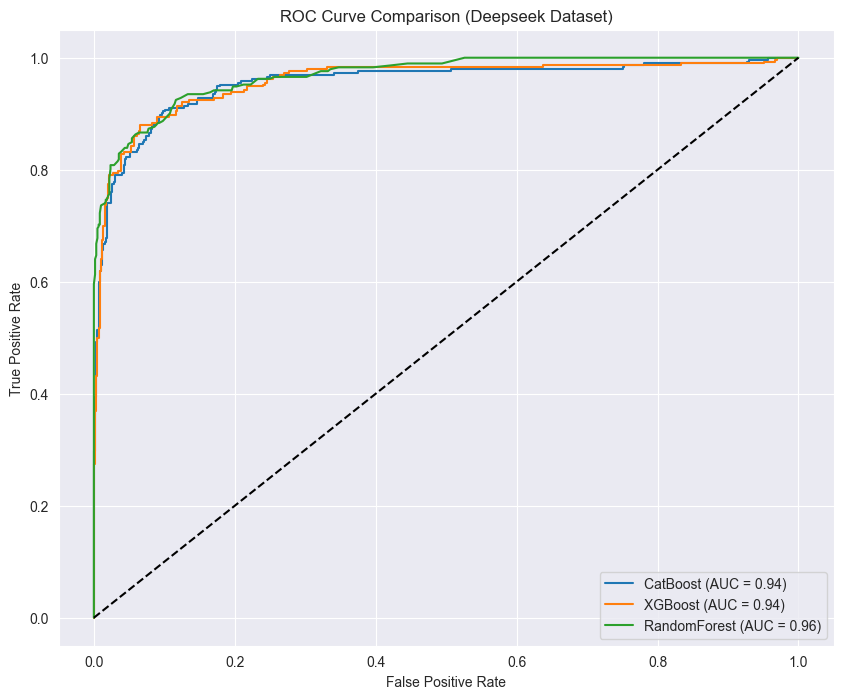

In [120]:
# Plot ROC curves for deepseek dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_deepseek.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Deepseek Dataset)')
plt.legend(loc='lower right')
plt.show()


# Copilot with basic params

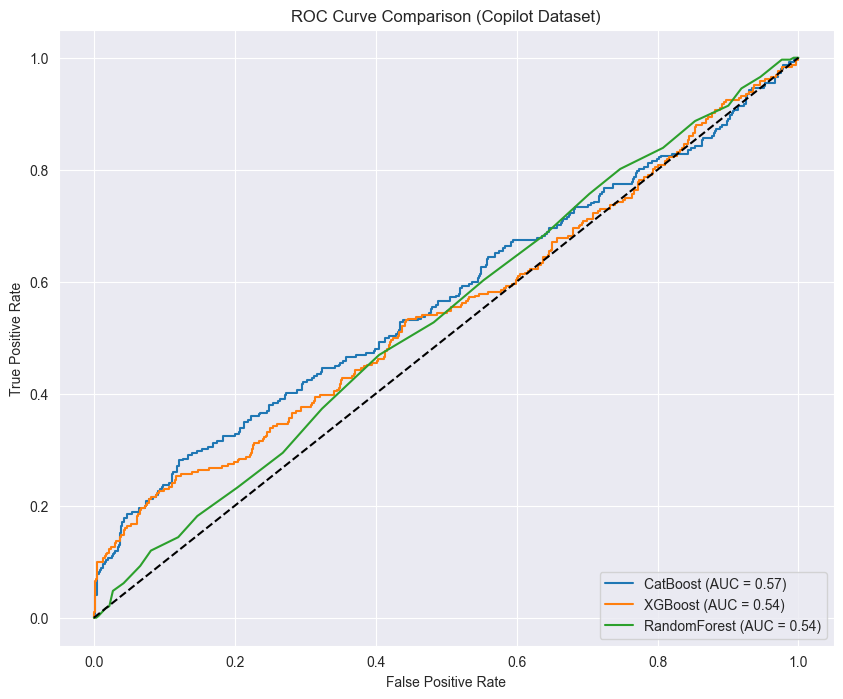

In [121]:
# Plot ROC curves for copilot dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_copilot.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Copilot Dataset)')
plt.legend(loc='lower right')
plt.show()

In [122]:
# Print results for deepseek dataset
print("\nResults for Deepseek Dataset:")
for model_name, result in results_deepseek.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Results for Deepseek Dataset:

Model: CatBoost
Accuracy: 0.8588
Precision: 0.8558
Recall: 0.8588
F1-Score: 0.8539
ROC-AUC: 0.9376

Model: XGBoost
Accuracy: 0.8588
Precision: 0.8554
Recall: 0.8588
F1-Score: 0.8557
ROC-AUC: 0.9398

Model: RandomForest
Accuracy: 0.8576
Precision: 0.8557
Recall: 0.8576
F1-Score: 0.8515
ROC-AUC: 0.9567


In [123]:
# Print results for copilot dataset
print("\nResults for Copilot Dataset:")
for model_name, result in results_copilot.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Results for Copilot Dataset:

Model: CatBoost
Accuracy: 0.3627
Precision: 0.4174
Recall: 0.3627
F1-Score: 0.3428
ROC-AUC: 0.5702

Model: XGBoost
Accuracy: 0.3198
Precision: 0.3663
Recall: 0.3198
F1-Score: 0.2947
ROC-AUC: 0.5417

Model: RandomForest
Accuracy: 0.3593
Precision: 0.4411
Recall: 0.3593
F1-Score: 0.3568
ROC-AUC: 0.5388


# Loading the model and getting the prompt for Mistral

In [124]:
# Завантажуємо ваш датасет
print("Завантажуємо df_sliced.csv...")
try:
    df_sliced = pd.read_csv('df_sliced.csv')
    print(f"Датасет завантажено! Розмір: {df_sliced.shape}")
    print(f"Колонки: {list(df_sliced.columns)}")
except FileNotFoundError:
    print("Файл df_sliced.csv не знайдено в поточній директорії")
    exit()

def analyze_dataset_structure(df):
    """Детальний аналіз структури датасету для створення промпта"""
    analysis = {}

    print("\n🔍 Аналізуємо структуру датасету...")

    for column in df.columns:
        col_data = df[column].dropna()  # Видаляємо NaN для аналізу

        col_info = {
            'dtype': str(df[column].dtype),
            'unique_count': df[column].nunique(),
            'null_count': df[column].isna().sum(),
            'sample_values': col_data.head(5).tolist() if len(col_data) > 0 else []
        }

        # Визначаємо тип колонки та її характеристики
        if df[column].dtype in ['int64', 'float64']:
            if col_info['unique_count'] <= 10:
                col_info['type'] = 'categorical_numeric'
                col_info['values'] = sorted(col_data.unique().tolist())
            else:
                col_info['type'] = 'continuous_numeric'
                col_info['min'] = float(col_data.min())
                col_info['max'] = float(col_data.max())
                col_info['mean'] = float(col_data.mean())
                col_info['std'] = float(col_data.std()) if col_data.std() > 0 else 1.0
        else:
            col_info['type'] = 'categorical'
            value_counts = df[column].value_counts()
            col_info['values'] = value_counts.index.tolist()
            col_info['proportions'] = (value_counts / len(df)).tolist()

        analysis[column] = col_info

    return analysis

Завантажуємо df_sliced.csv...
Датасет завантажено! Розмір: (442, 37)
Колонки: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without eval

In [125]:
def create_detailed_prompt(df, analysis):
    """Створює детальний промпт для Mistral з повною інформацією про датасет"""

    # Розділяємо колонки за типами
    categorical_numeric = []
    continuous_numeric = []
    categorical = []

    for col, info in analysis.items():
        if info['type'] == 'categorical_numeric':
            categorical_numeric.append((col, info))
        elif info['type'] == 'continuous_numeric':
            continuous_numeric.append((col, info))
        else:
            categorical.append((col, info))

    prompt = f"""You are an expert Python programmer. Generate ONLY clean Python code that creates a synthetic dataset 10 times larger than the original.

DATASET INFO:
- Original size: {df.shape[0]} rows, {df.shape[1]} columns
- Target size: {df.shape[0] * 10} rows
- Input variable name: df_sliced

COLUMN SPECIFICATIONS:

"""

    # Додаємо інформацію про кожну колонку
    for col, info in analysis.items():
        prompt += f"Column '{col}':\n"

        if info['type'] == 'categorical_numeric':
            prompt += f"  Type: Discrete numeric (values: {info['values']})\n"

        elif info['type'] == 'continuous_numeric':
            prompt += f"  Type: Continuous numeric\n"
            prompt += f"  Range: {info['min']:.3f} to {info['max']:.3f}\n"
            prompt += f"  Mean: {info['mean']:.3f}, Std: {info['std']:.3f}\n"

        else:
            prompt += f"  Type: Categorical\n"
            prompt += f"  Values: {info['values'][:5]}{'...' if len(info['values']) > 5 else ''}\n"
            if 'proportions' in info:
                main_props = [(info['values'][i], info['proportions'][i]) for i in range(min(3, len(info['values'])))]
                prompt += f"  Main proportions: {main_props}\n"

        prompt += "\n"

    prompt += f"""
REQUIREMENTS:
1. Create variable 'mistral:instruct_df' with exactly {df.shape[0] * 10} rows
2. Use pandas syntax: df_sliced['column_name'] (always with quotes)
3. Import required libraries: pandas as pd, numpy as np
4. Set random seed: np.random.seed(42)
5. For categorical columns: preserve original proportions using np.random.choice
6. For numeric columns: use appropriate distributions (normal, uniform, etc.)
7. Handle integer columns properly (round and convert to int)
8. No comments, no explanations, just working code

CODE STRUCTURE:
```python
import pandas as pd
import numpy as np

np.random.seed(42)
n_rows = {df.shape[0] * 10}

# Create synthetic data dictionary
synthetic_data = {{}}

# Generate each column based on original data patterns
[COLUMN GENERATION CODE HERE]

# Create final DataFrame
mistral_instruct_df = pd.DataFrame(synthetic_data)
```

Generate ONLY the Python code, no markdown formatting, no explanations.
IMPORTANT: The final variable MUST be named 'mistral_instruct_df', not 'synthetic_df'."""

    return prompt

In [126]:
def clean_mistral_code(code_text):
    """Очищає код від Mistral від зайвого форматування"""
    # Видаляємо markdown блоки
    code_text = re.sub(r'```python\s*\n?', '', code_text)
    code_text = re.sub(r'```\s*$', '', code_text)
    code_text = re.sub(r'^```\s*', '', code_text)

    # Видаляємо зайві пробіли та табуляції на початку
    lines = code_text.split('\n')
    cleaned_lines = []

    for line in lines:

        if not line.strip() and len(cleaned_lines) == 0:
            continue
        cleaned_lines.append(line)

    # Видаляємо порожні рядки в кінці
    while cleaned_lines and not cleaned_lines[-1].strip():
        cleaned_lines.pop()

    return '\n'.join(cleaned_lines)

In [43]:
# Основна логіка
print("\nАналізуємо структуру датасету...")
dataset_analysis = analyze_dataset_structure(df_sliced)

print(f"\nЗнайдено колонок:")
categorical_numeric = sum(1 for info in dataset_analysis.values() if info['type'] == 'categorical_numeric')
continuous_numeric = sum(1 for info in dataset_analysis.values() if info['type'] == 'continuous_numeric')
categorical = sum(1 for info in dataset_analysis.values() if info['type'] == 'categorical')

print(f"  Дискретні числові: {categorical_numeric}")
print(f"  Неперервні числові: {continuous_numeric}")
print(f"  Категорійні: {categorical}")

print(f"\nСтворюємо промпт для Mistral...")
detailed_prompt = create_detailed_prompt(df_sliced, dataset_analysis)

print(f"Розмір промпта: {len(detailed_prompt)} символів")
print(f"Відправляємо запит до Mistral...")



Аналізуємо структуру датасету...

🔍 Аналізуємо структуру датасету...

Знайдено колонок:
  Дискретні числові: 17
  Неперервні числові: 20
  Категорійні: 0

Створюємо промпт для Mistral...
Розмір промпта: 5079 символів
Відправляємо запит до Mistral...


In [44]:
try:
    # Генеруємо код через Mistral
    response = generate(model="mistral:instruct", prompt=detailed_prompt)
    generated_code = response['response']

    print(f"Код отримано! Розмір: {len(generated_code)} символів")

    # Очищаємо код
    clean_code = clean_mistral_code(generated_code)

    print(f"\nЗГЕНЕРОВАНИЙ КОД:")
    print("=" * 60)
    print(clean_code)
    print("=" * 60)

    # Тестуємо згенерований код
    print(f"\n⚡ Тестуємо згенерований код...")

    exec_globals = {
        'pd': pd,
        'np': np,
        'df_sliced': df_sliced,
        '__builtins__': {'len': len, 'range': range, 'print': print, 'min': min, 'max': max}
    }

    exec(clean_code, exec_globals)

    # Перевіряємо результат
    if 'mistral_instruct_df' in exec_globals:
        mistral_instruct_df = exec_globals['mistral_instruct_df']

        if isinstance(mistral_instruct_df, pd.DataFrame):
            print(f"УСПІХ! Створено синтетичний датасет:")
            print(f"Розмір: {mistral_instruct_df.shape}")
            print(f"Коефіцієнт збільшення: {len(mistral_instruct_df) / len(df_sliced):.1f}x")

            # Перевіряємо колонки
            missing_cols = set(df_sliced.columns) - set(mistral_instruct_df.columns)
            extra_cols = set(mistral_instruct_df.columns) - set(df_sliced.columns)

            if missing_cols:
                print(f"Відсутні колонки: {missing_cols}")
            if extra_cols:
                print(f"Зайві колонки: {extra_cols}")

            if not missing_cols and not extra_cols:
                print(f"Всі колонки на місці!")

            # Показуємо перші рядки
            print(f"\n Перші 3 рядки синтетичних даних:")
            print(mistral_instruct_df.head(3))

            # Зберігаємо
            output_file = 'mistral_instruct_dataset_10x.csv'
            mistral_instruct_df.to_csv(output_file, index=False)
            print(f"\n Збережено у файл: {output_file}")

            # Збереження згенерованого коду
            with open('generated_mistral_instruct_code.py', 'w', encoding='utf-8') as f:
                f.write("# Код згенерований Mistral для створення синтетичного датасету\n")
                f.write("# Результат зберігається у змінній mistral_instruct_df\n\n")
                f.write(clean_code)
            print(f" Код збережено у: generated_mistral_instruct_code.py")

        else:
            print(f" mistral_instruct_df має неправильний тип: {type(mistral_instruct_df)}")
    else:
        print(f" Змінна 'mistral_instruct_df' не створена")
        print(f"Доступні змінні: {list(exec_globals.keys())}")

except Exception as e:
    print(f"Помилка: {e}")
    print(f"Тип помилки: {type(e).__name__}")

    # Показуємо проблемний код для діагностики
    print(f"\n Згенерований код для діагностики:")
    print("-" * 40)
    lines = clean_code.split('\n')
    for i, line in enumerate(lines[:15], 1):
        print(f"{i:2d}: {repr(line)}")
    if len(lines) > 15:
        print("    ...")
    print("-" * 40)

print(f"\n Готово! Mistral згенерував код для створення синтетичного датасету.")

Код отримано! Розмір: 3453 символів

ЗГЕНЕРОВАНИЙ КОД:
 import pandas as pd
import numpy as np

np.random.seed(42)
n_rows = 4420

synthetic_data = {}

synthetic_data['Marital status'] = np.random.choice([1, 2, 4, 5], size=(n_rows,), p=[0.37, 0.39, 0.18, 0.06])
synthetic_data['Application mode'] = np.random.uniform(1, 53, n_rows)
synthetic_data['Application order'] = np.random.choice([1, 2, 3, 4, 5, 6], size=(n_rows,), replace=True)
synthetic_data['Course'] = np.random.uniform(33000, 9991000, n_rows)
synthetic_data['Daytime/evening attendance'] = np.random.choice([0, 1], size=(n_rows,))
synthetic_data['Previous qualification'] = np.random.uniform(1, 43, n_rows)
synthetic_data['Previous qualification (grade)'] = np.random.uniform(95, 182, n_rows)
synthetic_data['Nacionality'] = np.random.choice([1, 6, 22, 25, 41, 62, 105], size=(n_rows,))
synthetic_data['Mother''s qualification'] = np.random.uniform(1, 40, n_rows)
synthetic_data['Father''s qualification'] = np.random.uniform(1, 40, n_row

Mistral:instruct prompt Result and Training

In [127]:
np.random.seed(42)
n_rows = 4420

synthetic_data = {}
synthetic_data['Marital status'] = np.random.choice([1, 2, 4, 5], size=(n_rows,), p=[0.7, 0.1, 0.15, 0.05])
synthetic_data['Application mode'] = np.random.uniform(low=1.000, high=53000.0, size=(n_rows,))
synthetic_data['Application order'] = np.random.choice([1, 2, 3, 4, 5, 6], size=(n_rows,))
synthetic_data['Course'] = np.random.uniform(low=33000.0, high=99910000.0, size=(n_rows,)).round()
synthetic_data['Daytime/evening attendance'] = np.random.choice([0, 1], size=(n_rows,))
synthetic_data['Previous qualification'] = np.random.uniform(low=1.000, high=43000.0, size=(n_rows,)).round()
synthetic_data['Previous qualification (grade)'] = np.random.uniform(low=95000.0, high=182000.0, size=(n_rows,)).round()
synthetic_data['Nacionality'] = np.random.choice([1, 6, 22, 25, 41, 62, 105], size=(n_rows,))
synthetic_data['Mother’s qualification'] = np.random.uniform(low=1.000, high=40000.0, size=(n_rows,)).round()
synthetic_data['Father’s qualification'] = np.random.uniform(low=1.000, high=40000.0, size=(n_rows,)).round()
synthetic_data['Mother’s occupation'] = np.random.uniform(low=0.000, high=194000.0, size=(n_rows,)).round()
synthetic_data['Father’s occupation'] = np.random.uniform(low=0.000, high=181000.0, size=(n_rows,)).round()
synthetic_data['Admission grade'] = np.random.uniform(low=95000.0, high=180400.0, size=(n_rows,)).round()
synthetic_data['Displaced'] = np.random.choice([0, 1], size=(n_rows,))
synthetic_data['Educational special needs'] = np.random.choice([0, 1], size=(n_rows,))
synthetic_data['Debtor'] = np.random.choice([0, 1], size=(n_rows,))
synthetic_data['Tuition fees up to date'] = np.random.choice([0, 1], size=(n_rows,))
synthetic_data['Gender'] = np.random.choice([0, 1], size=(n_rows,))
synthetic_data['Scholarship holder'] = np.random.choice([0, 1], size=(n_rows,))
synthetic_data['Age at enrollment'] = np.random.uniform(low=18.000, high=55.000, size=(n_rows,)).round()
synthetic_data['International'] = np.random.choice([0, 1], size=(n_rows,))
synthetic_data['Curricular units 1st sem (credited)'] = np.random.uniform(low=0.000, high=20.000, size=(n_rows,)).round()
synthetic_data['Curricular units 1st sem (enrolled)'] = np.random.uniform(low=0.000, high=26.000, size=(n_rows,)).round()
synthetic_data['Curricular units 1st sem (evaluations)'] = np.random.uniform(low=0.000, high=32.000, size=(n_rows,)).round()
synthetic_data['Curricular units 1st sem (approved)'] = np.random.uniform(low=0.000, high=26.000, size=(n_rows,)).round()
synthetic_data['Curricular units 1st sem (grade)'] = np.random.uniform(low=0.000, high=17.111, size=(n_rows,)).round()
synthetic_data['Curricular units 1st sem (without evaluations)'] = np.random.choice([0, 1, 2, 3, 4, 5], size=(n_rows,))
synthetic_data['Curricular units 2nd sem (credited)'] = np.random.uniform(low=0.000, high=14.000, size=(n_rows,)).round()
synthetic_data['Curricular units 2nd sem (enrolled)'] = np.random.uniform(low=0.000, high=17.000, size=(n_rows,)).round()
synthetic_data['Curricular units 2nd sem (evaluations)'] = np.random.uniform(low=0.000, high=20.000, size=(n_rows,)).round()
synthetic_data['Curricular units 2nd sem (approved)'] = np.random.uniform(low=0.000, high=17.000, size=(n_rows,)).round()
synthetic_data['Curricular units 2nd sem (grade)'] = np.random.uniform(low=0.000, high=16.667, size=(n_rows,)).round()
synthetic_data['Curricular units 2nd sem (without evaluations)'] = np.random.choice([0, 1, 2, 4, 5], size=(n_rows,))
synthetic_data['Unemployment rate'] = np.random.choice([7.6, 8.9, 9.4, 10.8, 11.1, 12.4, 12.7, 13.9, 15.5, 16.2], size=(n_rows,))
synthetic_data['Inflation rate'] = np.random.choice([-0.8, -0.3, 0.3, 0.5, 0.6, 1.4, 2.6, 2.8, 3.7], size=(n_rows,))
synthetic_data['GDP'] = np.random.choice([-4.06, -3.12, -1.7, -0.92, 0.32, 0.79, 1.74, 1.79, 2.02, 3.51], size=(n_rows,))
synthetic_data['Target_encoded'] = np.random.choice([0, 1, 2], size=(n_rows,))

mistral_instruct_df = pd.DataFrame(synthetic_data)

In [128]:
X_train_mistral, X_test_mistral, y_train_mistral, y_test_mistral = prepare_datasets(mistral_instruct_df)

In [129]:
X_sliced = df_sliced.drop('Target_encoded', axis=1)
y_sliced = df_sliced['Target_encoded']

sliced_dataset = X_sliced.copy()
sliced_dataset['Target_encoded'] = y_sliced

In [130]:
def clean_columns(df):
    return (
        df.rename(columns=lambda x: str(x).strip())  # прибрати пробіли/табуляції
        .rename(columns=lambda x: x.replace("’", "'"))  # замінити "розумний" апостроф на звичайний
    )

In [131]:
X_train_mistral = clean_columns(X_train_mistral)
X_test_mistral = clean_columns(X_test_mistral)
X_test_full = clean_columns(X_test_full)

In [132]:
mistral_instruct_result = {}
for model_name, model in models.items():
    print(f"Training {model_name} on Mistral-generated dataset...")
    mistral_instruct_result[model_name] = evaluate_model(model, X_train_mistral, y_train_mistral, X_test_full,
                                                         y_test_full)

Training CatBoost on Mistral-generated dataset...
Training XGBoost on Mistral-generated dataset...


E:\Research\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:52:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest on Mistral-generated dataset...


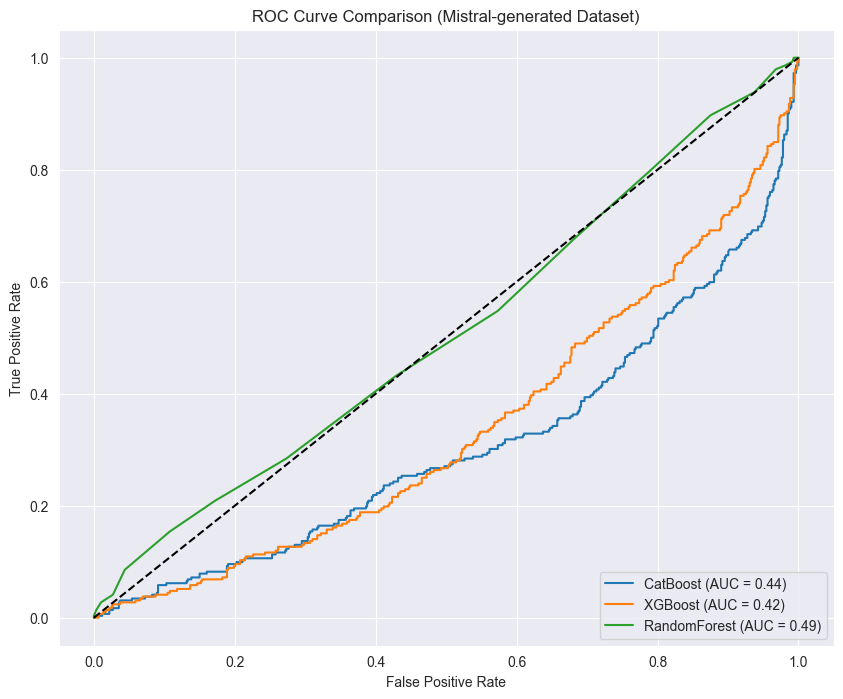

In [133]:
# *GPT-dataset basic params*
# Plot ROC curves for GPT-generated dataset
plt.figure(figsize=(10, 8))
for model_name, result in mistral_instruct_result.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Mistral-generated Dataset)')
plt.legend(loc='lower right')
plt.show()

In [134]:
# Print results for Mistral-generated dataset
for model_name, result in mistral_instruct_result.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.1684
Precision: 0.4300
Recall: 0.1684
F1-Score: 0.1067
ROC-AUC: 0.4419

Model: XGBoost
Accuracy: 0.2463
Precision: 0.2822
Recall: 0.2463
F1-Score: 0.1938
ROC-AUC: 0.4232

Model: RandomForest
Accuracy: 0.2734
Precision: 0.3029
Recall: 0.2734
F1-Score: 0.1986
ROC-AUC: 0.4870


# Loading the model and getting the result for Llama3.1 8b

In [135]:
# Завантажуємо ваш датасет
print("Завантажуємо df_sliced.csv...")
try:
    df_sliced = pd.read_csv('df_sliced.csv')
    print(f"Датасет завантажено! Розмір: {df_sliced.shape}")
    print(f"Колонки: {list(df_sliced.columns)}")
except FileNotFoundError:
    print("Файл df_sliced.csv не знайдено в поточній директорії")
    exit()

def analyze_dataset_structure(df):
    """Детальний аналіз структури датасету для створення промпта"""
    analysis = {}

    print("\n🔍 Аналізуємо структуру датасету...")

    for column in df.columns:
        col_data = df[column].dropna()  # Видаляємо NaN для аналізу

        col_info = {
            'dtype': str(df[column].dtype),
            'unique_count': df[column].nunique(),
            'null_count': df[column].isna().sum(),
            'sample_values': col_data.head(5).tolist() if len(col_data) > 0 else []
        }

        # Визначаємо тип колонки та її характеристики
        if df[column].dtype in ['int64', 'float64']:
            if col_info['unique_count'] <= 10:
                col_info['type'] = 'categorical_numeric'
                col_info['values'] = sorted(col_data.unique().tolist())
            else:
                col_info['type'] = 'continuous_numeric'
                col_info['min'] = float(col_data.min())
                col_info['max'] = float(col_data.max())
                col_info['mean'] = float(col_data.mean())
                col_info['std'] = float(col_data.std()) if col_data.std() > 0 else 1.0
        else:
            col_info['type'] = 'categorical'
            value_counts = df[column].value_counts()
            col_info['values'] = value_counts.index.tolist()
            col_info['proportions'] = (value_counts / len(df)).tolist()

        analysis[column] = col_info

    return analysis

Завантажуємо df_sliced.csv...
Датасет завантажено! Розмір: (442, 37)
Колонки: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without eval

In [54]:
def create_detailed_prompt(df, analysis):
    """Створює детальний промпт для Mistral з повною інформацією про датасет"""

    # Розділяємо колонки за типами
    categorical_numeric = []
    continuous_numeric = []
    categorical = []

    for col, info in analysis.items():
        if info['type'] == 'categorical_numeric':
            categorical_numeric.append((col, info))
        elif info['type'] == 'continuous_numeric':
            continuous_numeric.append((col, info))
        else:
            categorical.append((col, info))

    prompt = f"""You are an expert Python programmer. Generate ONLY clean Python code that creates a synthetic dataset 10 times larger than the original.

DATASET INFO:
- Original size: {df.shape[0]} rows, {df.shape[1]} columns
- Target size: {df.shape[0] * 10} rows
- Input variable name: df_sliced

COLUMN SPECIFICATIONS:

"""

    # Додаємо інформацію про кожну колонку
    for col, info in analysis.items():
        prompt += f"Column '{col}':\n"

        if info['type'] == 'categorical_numeric':
            prompt += f"  Type: Discrete numeric (values: {info['values']})\n"

        elif info['type'] == 'continuous_numeric':
            prompt += f"  Type: Continuous numeric\n"
            prompt += f"  Range: {info['min']:.3f} to {info['max']:.3f}\n"
            prompt += f"  Mean: {info['mean']:.3f}, Std: {info['std']:.3f}\n"

        else:
            prompt += f"  Type: Categorical\n"
            prompt += f"  Values: {info['values'][:5]}{'...' if len(info['values']) > 5 else ''}\n"
            if 'proportions' in info:
                main_props = [(info['values'][i], info['proportions'][i]) for i in range(min(3, len(info['values'])))]
                prompt += f"  Main proportions: {main_props}\n"

        prompt += "\n"

    prompt += f"""
REQUIREMENTS:
1. Create variable 'mistral:instruct_df' with exactly {df.shape[0] * 10} rows
2. Use pandas syntax: df_sliced['column_name'] (always with quotes)
3. Import required libraries: pandas as pd, numpy as np
4. Set random seed: np.random.seed(42)
5. For categorical columns: preserve original proportions using np.random.choice
6. For numeric columns: use appropriate distributions (normal, uniform, etc.)
7. Handle integer columns properly (round and convert to int)
8. No comments, no explanations, just working code

CODE STRUCTURE:
```python
import pandas as pd
import numpy as np

np.random.seed(42)
n_rows = {df.shape[0] * 10}

# Create synthetic data dictionary
synthetic_data = {{}}

# Generate each column based on original data patterns
[COLUMN GENERATION CODE HERE]

# Create final DataFrame
mistral_instruct_df = pd.DataFrame(synthetic_data)
```

Generate ONLY the Python code, no markdown formatting, no explanations.
IMPORTANT: The final variable MUST be named 'mistral_instruct_df', not 'synthetic_df'."""

    return prompt

In [55]:
def clean_mistral_code(code_text):
    """Очищає код від Mistral від зайвого форматування"""
    # Видаляємо markdown блоки
    code_text = re.sub(r'```python\s*\n?', '', code_text)
    code_text = re.sub(r'```\s*$', '', code_text)
    code_text = re.sub(r'^```\s*', '', code_text)

    # Видаляємо зайві пробіли та табуляції на початку
    lines = code_text.split('\n')
    cleaned_lines = []

    for line in lines:

        if not line.strip() and len(cleaned_lines) == 0:
            continue
        cleaned_lines.append(line)

    # Видаляємо порожні рядки в кінці
    while cleaned_lines and not cleaned_lines[-1].strip():
        cleaned_lines.pop()

    return '\n'.join(cleaned_lines)

In [56]:
# Основна логіка
print("\nАналізуємо структуру датасету...")
dataset_analysis = analyze_dataset_structure(df_sliced)

print(f"\nЗнайдено колонок:")
categorical_numeric = sum(1 for info in dataset_analysis.values() if info['type'] == 'categorical_numeric')
continuous_numeric = sum(1 for info in dataset_analysis.values() if info['type'] == 'continuous_numeric')
categorical = sum(1 for info in dataset_analysis.values() if info['type'] == 'categorical')

print(f"  Дискретні числові: {categorical_numeric}")
print(f"  Неперервні числові: {continuous_numeric}")
print(f"  Категорійні: {categorical}")

print(f"\nСтворюємо промпт для Mistral...")
detailed_prompt = create_detailed_prompt(df_sliced, dataset_analysis)

print(f"Розмір промпта: {len(detailed_prompt)} символів")
print(f"Відправляємо запит до Mistral...")



Аналізуємо структуру датасету...

🔍 Аналізуємо структуру датасету...

Знайдено колонок:
  Дискретні числові: 17
  Неперервні числові: 20
  Категорійні: 0

Створюємо промпт для Mistral...
Розмір промпта: 5079 символів
Відправляємо запит до Mistral...


In [57]:
response = generate(model="llama3.1:8b", prompt=detailed_prompt)
generated_code = response['response']

print(f"Код отримано! Розмір: {len(generated_code)} символів")

# Очищаємо код
clean_code = clean_mistral_code(generated_code)
print(f"\nЗГЕНЕРОВАНИЙ КОД:")
print("=" * 60)
print(clean_code)
print("=" * 60)


print(f"\n Готово! згенерував код для створення синтетичного датасету.")

Код отримано! Розмір: 3269 символів

ЗГЕНЕРОВАНИЙ КОД:
import pandas as pd
import numpy as np

np.random.seed(42)
n_rows = 4420

# Create synthetic data dictionary
synthetic_data = {}

# Discrete numeric columns
discrete_cols = ['Marital status', 'Application order', 'Daytime/evening attendance', 
                 'Nacionality', 'Curricular units 1st sem (without evaluations)', 
                 'Curricular units 2nd sem (without evaluations)', 'Displaced',
                 'Educational special needs', 'Debtor', 'Tuition fees up to date',
                 'Gender', 'Scholarship holder', 'International', 'Unemployment rate',
                 'Inflation rate', 'GDP', 'Target_encoded']

for col in discrete_cols:
    if col == 'Marital status':
        synthetic_data[col] = np.random.choice([1, 2, 4, 5], size=n_rows)
    elif col == 'Application order':
        synthetic_data[col] = np.random.choice([1, 2, 3, 4, 5, 6], size=n_rows)
    elif col == 'Daytime/evening attendance':
        synt

In [136]:
import pandas as pd
import numpy as np

np.random.seed(42)
n_rows = 4420

# Create synthetic data dictionary
synthetic_data = {}

# Generate categorical columns
categorical_cols = ['Marital status', 'Application order',
                    'Daytime/evening attendance	', 'Nacionality',
                    'Displaced', 'Educational special needs',
                    'Debtor', 'Tuition fees up to date', 'Gender',
                    'Scholarship holder', 'International',
                    'Curricular units 1st sem (without evaluations)',
                    'Curricular units 2nd sem (without evaluations)',
                    'Target_encoded']

for col in categorical_cols:
    if col == 'Marital status':
        synthetic_data[col] = np.random.choice([1, 2, 4, 5], size=n_rows)
    elif col == 'Application order':
        synthetic_data[col] = np.random.choice([1, 2, 3, 4, 5, 6], size=n_rows)
    elif col == 'Daytime/evening attendance	':
        synthetic_data[col] = np.random.choice([0, 1], size=n_rows)
    elif col == 'Nacionality':
        synthetic_data[col] = np.random.choice([1, 6, 22, 25, 41, 62, 105], size=n_rows)
    elif col == 'Displaced':
        synthetic_data[col] = np.random.choice([0, 1], size=n_rows)
    elif col == 'Educational special needs':
        synthetic_data[col] = np.random.choice([0, 1], size=n_rows)
    elif col == 'Debtor':
        synthetic_data[col] = np.random.choice([0, 1], size=n_rows)
    elif col == 'Tuition fees up to date':
        synthetic_data[col] = np.random.choice([0, 1], size=n_rows)
    elif col == 'Gender':
        synthetic_data[col] = np.random.choice([0, 1], size=n_rows)
    elif col == 'Scholarship holder':
        synthetic_data[col] = np.random.choice([0, 1], size=n_rows)
    elif col == 'International':
        synthetic_data[col] = np.random.choice([0, 1], size=n_rows)
    elif col == 'Curricular units 1st sem (without evaluations)':
        synthetic_data[col] = np.random.choice([0, 1, 2, 3, 4, 5], size=n_rows)
    elif col == 'Curricular units 2nd sem (without evaluations)':
        synthetic_data[col] = np.random.choice([0, 1, 2, 4, 5], size=n_rows)
    elif col == 'Target_encoded':
        synthetic_data[col] = np.random.choice([0, 1, 2], size=n_rows)

# Generate numeric columns
numeric_cols = ['Application mode', 'Course',
                'Previous qualification', 'Previous qualification (grade)',
                'Mother\'s qualification', 'Father\'s qualification',
                'Mother\'s occupation', 'Father\'s occupation',
                'Admission grade', 'Age at enrollment',
                'Curricular units 1st sem (credited)',
                'Curricular units 1st sem (enrolled)',
                'Curricular units 1st sem (evaluations)',
                'Curricular units 1st sem (approved)',
                'Curricular units 1st sem (grade)',
                'Curricular units 2nd sem (credited)',
                'Curricular units 2nd sem (enrolled)',
                'Curricular units 2nd sem (evaluations)',
                'Curricular units 2nd sem (approved)',
                'Curricular units 2nd sem (grade)',
                'Unemployment rate', 'Inflation rate', 'GDP']

for col in numeric_cols:
    if col == 'Application mode':
        synthetic_data[col] = np.round(np.random.uniform(1, 54, n_rows), decimals=3)
    elif col == 'Course':
        synthetic_data[col] = np.round(np.random.uniform(33, 9991, n_rows))
    elif col == 'Previous qualification':
        synthetic_data[col] = np.round(np.random.uniform(1, 43, n_rows))
    elif col == 'Previous qualification (grade)':
        synthetic_data[col] = np.round(np.random.uniform(95, 182, n_rows), decimals=2)
    elif col == 'Mother\'s qualification':
        synthetic_data[col] = np.round(np.random.uniform(1, 40, n_rows), decimals=3)
    elif col == 'Father\'s qualification':
        synthetic_data[col] = np.round(np.random.uniform(1, 40, n_rows), decimals=3)
    elif col == 'Mother\'s occupation':
        synthetic_data[col] = np.round(np.random.uniform(0, 194, n_rows), decimals=2)
    elif col == 'Father\'s occupation':
        synthetic_data[col] = np.round(np.random.uniform(0, 181, n_rows), decimals=2)
    elif col == 'Admission grade':
        synthetic_data[col] = np.round(np.random.uniform(95, 180.4, n_rows), decimals=3)
    elif col == 'Age at enrollment':
        synthetic_data[col] = np.round(np.random.uniform(18, 55, n_rows))
    elif col == 'Curricular units 1st sem (credited)':
        synthetic_data[col] = np.round(np.random.uniform(0, 20, n_rows), decimals=2)
    elif col == 'Curricular units 1st sem (enrolled)':
        synthetic_data[col] = np.round(np.random.uniform(0, 26, n_rows))
    elif col == 'Curricular units 1st sem (evaluations)':
        synthetic_data[col] = np.round(np.random.uniform(0, 32, n_rows), decimals=2)
    elif col == 'Curricular units 1st sem (approved)':
        synthetic_data[col] = np.round(np.random.uniform(0, 26, n_rows))
    elif col == 'Curricular units 1st sem (grade)':
        synthetic_data[col] = np.round(np.random.uniform(0, 17.111, n_rows), decimals=2)
    elif col == 'Curricular units 2nd sem (credited)':
        synthetic_data[col] = np.round(np.random.uniform(0, 14, n_rows))
    elif col == 'Curricular units 2nd sem (enrolled)':
        synthetic_data[col] = np.round(np.random.uniform(0, 17, n_rows))
    elif col == 'Curricular units 2nd sem (evaluations)':
        synthetic_data[col] = np.round(np.random.uniform(0, 20, n_rows), decimals=2)
    elif col == 'Curricular units 2nd sem (approved)':
        synthetic_data[col] = np.round(np.random.uniform(0, 17, n_rows))
    elif col == 'Curricular units 2nd sem (grade)':
        synthetic_data[col] = np.round(np.random.uniform(0, 16.667, n_rows), decimals=3)
    elif col == 'Unemployment rate':
        unemployment_values = [7.6, 8.9, 9.4, 10.8, 11.1, 12.4, 12.7, 13.9, 15.5, 16.2]
        synthetic_data[col] = np.random.choice(unemployment_values, size=n_rows)
    elif col == 'Inflation rate':
        inflation_values = [-0.8, -0.3, 0.3, 0.5, 0.6, 1.4, 2.6, 2.8, 3.7]
        synthetic_data[col] = np.random.choice(inflation_values, size=n_rows)
    elif col == 'GDP':
        gdp_values = [-4.06, -3.12, -1.7, -0.92, 0.32, 0.79, 1.74, 1.79, 2.02, 3.51]
        synthetic_data[col] = np.random.choice(gdp_values, size=n_rows)

# Create final DataFrame
llama3_df = pd.DataFrame(synthetic_data)

In [137]:
X_train_llama3, X_test_llama3, y_train_llama3, y_test_llama3 = prepare_datasets(llama3_df)

In [138]:
X_sliced = df_sliced.drop('Target_encoded', axis=1)
y_sliced = df_sliced['Target_encoded']

sliced_dataset = X_sliced.copy()
sliced_dataset['Target_encoded'] = y_sliced

In [139]:
def clean_columns(df):
    return (
        df.rename(columns=lambda x: str(x).strip())  # прибрати пробіли/табуляції
        .rename(columns=lambda x: x.replace("’", "'"))  # замінити "розумний" апостроф на звичайний
    )

In [140]:
X_train_llama3 = clean_columns(X_train_llama3)
X_test_llama3 = clean_columns(X_test_llama3)
X_test_full = clean_columns(X_test_full)

# Фіксуємо порядок колонок з X_test_full
col_order = X_test_full.columns.tolist()

# Перевпорядковуємо X_train_llama3, X_test_llama3, тощо
X_train_llama3 = X_train_llama3[col_order]
X_test_llama3 = X_test_llama3[col_order]


In [141]:
llama3_result = {}
for model_name, model in models.items():
    print(f"Training {model_name} on Llama3-generated dataset...")
    llama3_result[model_name] = evaluate_model(model, X_train_llama3, y_train_llama3, X_test_full,
                                                         y_test_full)

Training CatBoost on Llama3-generated dataset...
Training XGBoost on Llama3-generated dataset...


E:\Research\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:53:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest on Llama3-generated dataset...


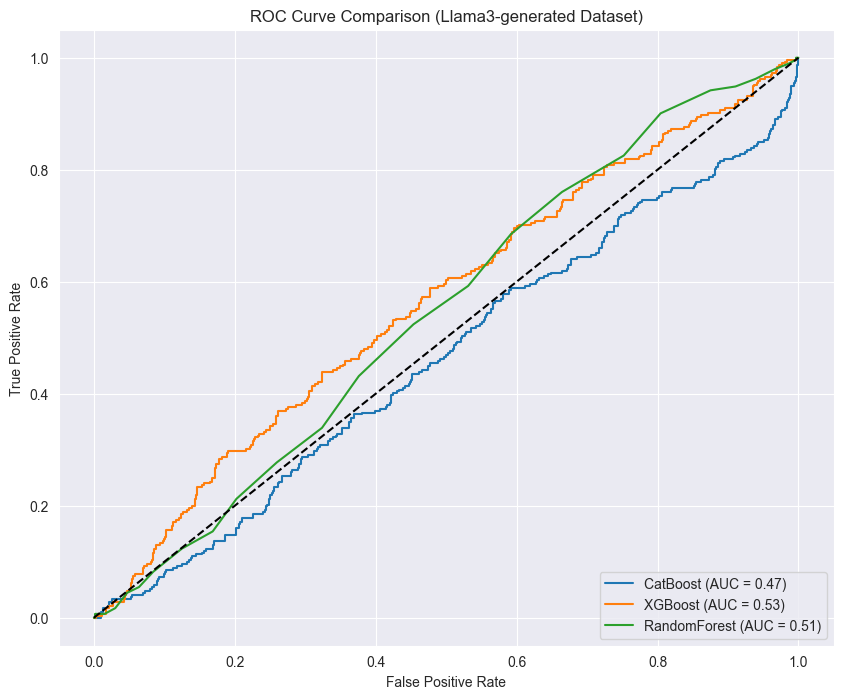

In [142]:
plt.figure(figsize=(10, 8))
for model_name, result in llama3_result.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Llama3-generated Dataset)')
plt.legend(loc='lower right')
plt.show()

In [143]:
for model_name, result in llama3_result.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.2000
Precision: 0.3408
Recall: 0.2000
F1-Score: 0.1632
ROC-AUC: 0.4734

Model: XGBoost
Accuracy: 0.2328
Precision: 0.4148
Recall: 0.2328
F1-Score: 0.2224
ROC-AUC: 0.5346

Model: RandomForest
Accuracy: 0.2407
Precision: 0.3449
Recall: 0.2407
F1-Score: 0.2395
ROC-AUC: 0.5076


## Evaluating all

In [144]:
# Evaluate better models on full dataset
better_results_full = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on full dataset...")
    better_results_full[better_model_name] = evaluate_model(better_model, X_train_full, y_train_full, X_test_full, y_test_full)

# Evaluate better models on sliced dataset
better_results_sliced = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on sliced dataset...")
    better_results_sliced[better_model_name] = evaluate_model(better_model, X_train_sliced, y_train_sliced, X_test_full, y_test_full)

# Evaluate better models on GPT-generated dataset
better_results_gpt = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on GPT-generated dataset...")
    better_results_gpt[better_model_name] = evaluate_model(better_model, X_train_full, y_train_full, X_test_full, y_test_full)

# Evaluate better models on deepseek dataset
better_results_deepseek = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on deepseek dataset...")
    better_results_deepseek[better_model_name] = evaluate_model(better_model, X_train_deepseek, y_train_deepseek, X_test_full, y_test_full)

# Evaluate better models on copilot dataset
better_results_copilot = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on copilot dataset...")
    better_results_copilot[better_model_name] = evaluate_model(better_model, X_train_copilot, y_train_copilot, X_test_full, y_test_full)

Training CatBoost with better parameters on full dataset...


CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 4 should be feature with name Daytime/evening attendance	 (found Daytime/evening attendance).

# All models plotting results

              Dataset         Model  Accuracy  Precision    Recall  F1-Score  \
0            Original      CatBoost  0.750282   0.741858  0.750282  0.744126   
1            Original       XGBoost  0.746893   0.740024  0.746893  0.740659   
2            Original  RandomForest  0.772881   0.765165  0.772881  0.763118   
3              Sliced      CatBoost  0.819209   0.815402  0.819209  0.811709   
4              Sliced       XGBoost  0.824859   0.819459  0.824859  0.820431   
5              Sliced  RandomForest  0.832768   0.829466  0.832768  0.823747   
6                 GPT      CatBoost  0.750282   0.741858  0.750282  0.744126   
7                 GPT       XGBoost  0.746893   0.740024  0.746893  0.740659   
8                 GPT  RandomForest  0.772881   0.765165  0.772881  0.763118   
9            Deepseek      CatBoost  0.849718   0.845348  0.849718  0.844818   
10           Deepseek       XGBoost  0.853107   0.849235  0.853107  0.849164   
11           Deepseek  RandomForest  0.8

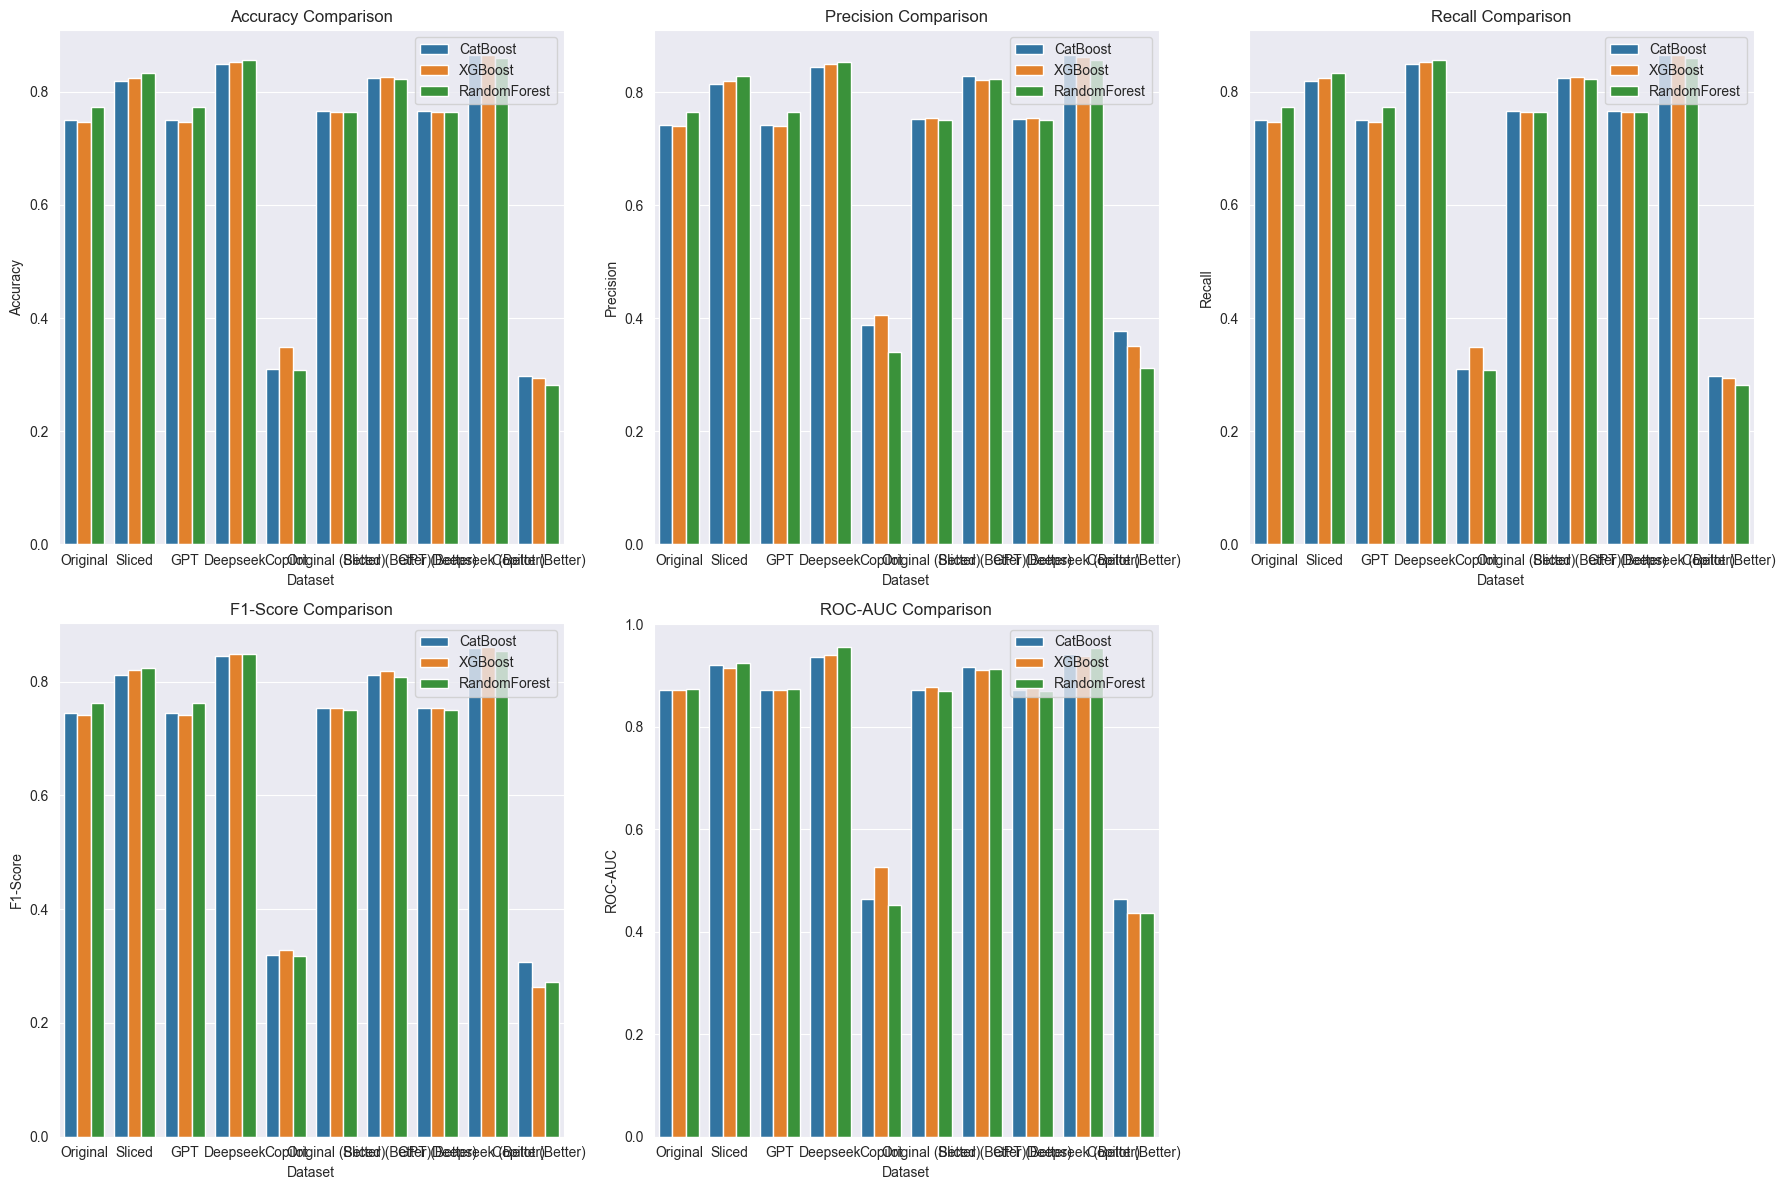

In [42]:
results = {
    'Dataset': [],
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC-AUC': []
}


for model_name, result in results_full.items():
    results['Dataset'].append('Original')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in results_sliced.items():
    results['Dataset'].append('Sliced')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in results_gpt.items():
    results['Dataset'].append('GPT')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])


for model_name, result in results_deepseek.items():
    results['Dataset'].append('Deepseek')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])


for model_name, result in results_copilot.items():
    results['Dataset'].append('Copilot')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])


for model_name, result in better_results_full.items():
    results['Dataset'].append('Original (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in better_results_sliced.items():
    results['Dataset'].append('Sliced (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in better_results_gpt.items():
    results['Dataset'].append('GPT (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in better_results_deepseek.items():
    results['Dataset'].append('Deepseek (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in better_results_copilot.items():
    results['Dataset'].append('Copilot (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])


results_df = pd.DataFrame(results)


print(results_df)


metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
plt.figure(figsize=(18, 12))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=results_df, x='Dataset', y=metric, hue='Model')
    plt.title(f'{metric} Comparison')
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Plotting basic params models

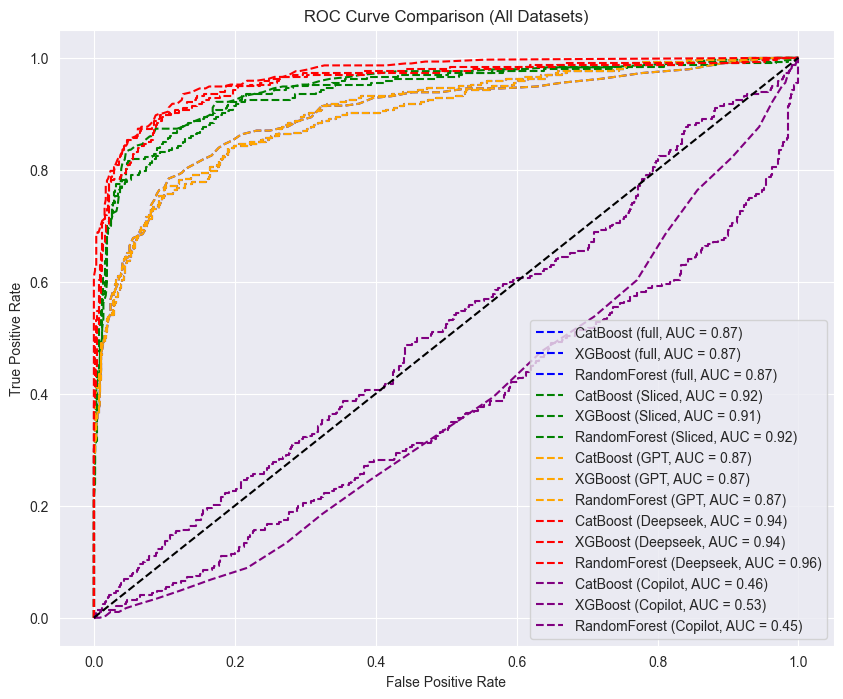

In [43]:
plt.figure(figsize=(10, 8))
for dataset, color in zip(['full', 'Sliced','GPT','Deepseek', 'Copilot'], ['blue', 'green', 'orange','red', 'purple','yellow']):
    for model_name, result in eval(f'results_{dataset.lower()}').items():
        fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
        plt.plot(fpr, tpr, label=f'{model_name} ({dataset}, AUC = {result["roc_auc"]:.2f})', color=color, linestyle='--' if dataset != 'Original' else '-')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (All Datasets)')
plt.legend(loc='lower right')
plt.show()

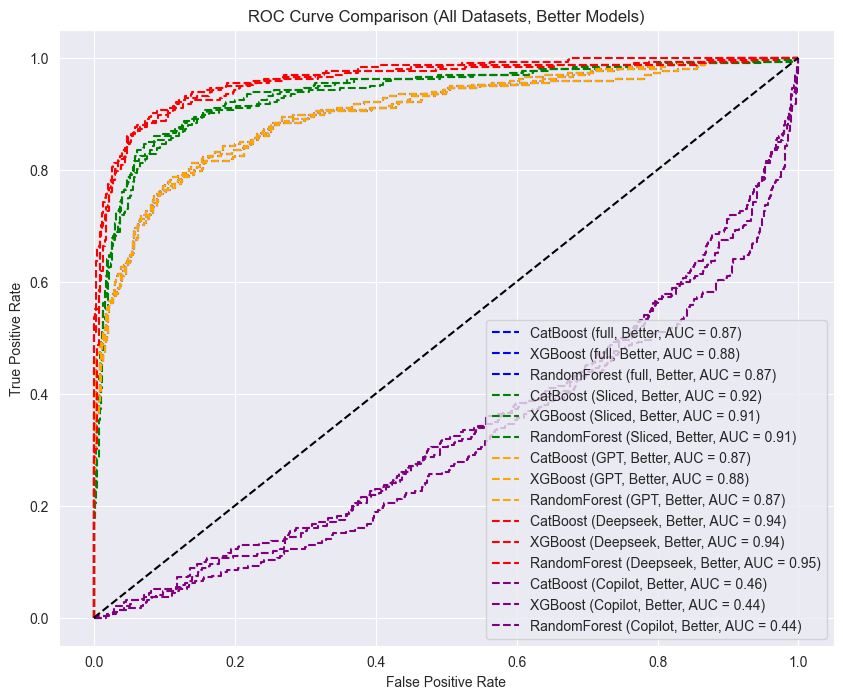

In [44]:
# Plot updated ROC curves
plt.figure(figsize=(10, 8))
for dataset, color in zip(['full', 'Sliced', 'GPT', 'Deepseek', 'Copilot'], ['blue', 'green', 'orange', 'red', 'purple', 'yellow']):
    for model_name, result in eval(f'better_results_{dataset.lower()}').items():
        fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
        plt.plot(fpr, tpr, label=f'{model_name} ({dataset}, Better, AUC = {result["roc_auc"]:.2f})', color=color, linestyle='--' if dataset != 'Original' else '-')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (All Datasets, Better Models)')
plt.legend(loc='lower right')
plt.show()

## Result for better params for all datasets

In [45]:
# Print results for better models on full dataset
print("\nResults for Better Models on Full Dataset:")
for model_name, result in better_results_full.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")

# Print results for better models on sliced dataset
print("\nResults for Better Models on Sliced Dataset:")
for model_name, result in better_results_sliced.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")

# Print results for better models on GPT-generated dataset
print("\nResults for Better Models on GPT-Generated Dataset:")
for model_name, result in better_results_gpt.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")

# Print results for better models on deepseek dataset
print("\nResults for Better Models on Deepseek Dataset:")
for model_name, result in better_results_deepseek.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")

# Print results for better models on copilot dataset
print("\nResults for Better Models on Copilot Dataset:")
for model_name, result in better_results_copilot.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Results for Better Models on Full Dataset:

Model: CatBoost
Accuracy: 0.7661
Precision: 0.7519
Recall: 0.7661
F1-Score: 0.7540
ROC-AUC: 0.8715

Model: XGBoost
Accuracy: 0.7638
Precision: 0.7539
Recall: 0.7638
F1-Score: 0.7542
ROC-AUC: 0.8780

Model: RandomForest
Accuracy: 0.7650
Precision: 0.7507
Recall: 0.7650
F1-Score: 0.7509
ROC-AUC: 0.8702

Results for Better Models on Sliced Dataset:

Model: CatBoost
Accuracy: 0.8237
Precision: 0.8285
Recall: 0.8237
F1-Score: 0.8109
ROC-AUC: 0.9176

Model: XGBoost
Accuracy: 0.8271
Precision: 0.8225
Recall: 0.8271
F1-Score: 0.8190
ROC-AUC: 0.9103

Model: RandomForest
Accuracy: 0.8226
Precision: 0.8232
Recall: 0.8226
F1-Score: 0.8090
ROC-AUC: 0.9131

Results for Better Models on GPT-Generated Dataset:

Model: CatBoost
Accuracy: 0.7661
Precision: 0.7519
Recall: 0.7661
F1-Score: 0.7540
ROC-AUC: 0.8715

Model: XGBoost
Accuracy: 0.7638
Precision: 0.7539
Recall: 0.7638
F1-Score: 0.7542
ROC-AUC: 0.8780

Model: RandomForest
Accuracy: 0.7650
Precision: 0.7

In [46]:
df.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969,0.680154
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935,0.759359
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000,1.000000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000,1.000000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000,2.000000


In [47]:
df_sliced.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,...,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,1.167421,18.294118,1.683258,8910.115385,0.909502,4.361991,132.630543,1.859729,17.052036,20.789593,...,0.502262,6.192308,7.830317,4.452489,10.400820,0.128959,11.663348,1.067195,-0.061448,0.671946
std,0.609097,17.262398,1.215598,1992.980304,0.287219,9.945895,12.782673,7.011054,14.976308,15.469774,...,1.738257,2.074931,3.618507,2.897142,5.200203,0.570732,2.570735,1.404313,2.269422,0.739909
min,1.000000,1.000000,1.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,1.000000,3.000000,...,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,6.000000,8.000000,5.000000,12.333333,0.000000,11.100000,0.600000,0.320000,1.000000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,13.900000,2.600000,1.790000,1.000000
max,5.000000,53.000000,6.000000,9991.000000,1.000000,43.000000,182.000000,105.000000,40.000000,40.000000,...,14.000000,17.000000,20.000000,17.000000,16.666667,5.000000,16.200000,3.700000,3.510000,2.000000


In [48]:
df_copilot.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,...,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000
mean,1.192671,18.205723,1.711582,8871.004226,0.912281,4.468639,132.991925,1.753798,16.677664,20.628891,...,0.500287,6.180148,7.814691,4.433271,10.581424,0.138617,11.612881,1.045142,-0.067057,0.981222
std,0.613551,17.422090,1.244606,1964.922255,0.286451,9.760379,12.673860,6.971645,14.939633,15.436991,...,1.741271,2.055369,3.608019,2.920925,5.146352,0.575593,2.578055,1.371442,2.238939,0.814199
min,-1.332580,-38.300262,-3.119095,2169.028809,-0.224286,-28.895531,84.174284,-23.294262,-34.365031,-30.654245,...,-5.438805,-1.334567,-5.671783,-5.632954,-9.545170,-1.857843,1.678618,-4.422287,-7.782074,0.000000
25%,0.767383,6.535883,0.888763,7553.825965,0.720314,-2.116570,124.289375,-2.968930,6.613971,10.226376,...,-0.639970,4.795890,5.389209,2.432974,7.065031,-0.249419,9.861244,0.123347,-1.614415,0.000000
50%,1.194382,18.349127,1.722487,8859.850992,0.912456,4.459333,132.932561,1.826854,16.440294,20.551963,...,0.474452,6.187141,7.890888,4.415528,10.638626,0.132076,11.638386,1.063854,-0.043235,1.000000
75%,1.617236,29.762493,2.557420,10208.391760,1.103986,10.988303,141.482841,6.362723,26.762229,30.713005,...,1.692608,7.529007,10.210766,6.421089,14.201144,0.529863,13.340909,1.953672,1.501758,2.000000
max,3.588574,91.275470,7.265207,16592.972896,1.899915,36.934602,181.120194,24.745738,69.566984,80.263504,...,7.936098,13.788027,21.945410,15.622986,29.654466,2.271755,21.016333,6.314647,7.981159,2.000000


In [77]:
df_gpt = pd.read_csv('E:/Research/synthetic_dataset.csv')

In [78]:
df_gpt.describe()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,...,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000
mean,1.159276,18.476697,1.664706,8887.362443,0.914480,4.460407,132.520360,1.880995,16.869231,20.907692,...,0.488914,6.216063,7.717904,4.505204,10.438599,0.130543,11.707489,1.060271,-0.107265,0.676471
std,0.583369,17.313390,1.201859,2048.238672,0.279686,10.134578,12.792340,6.866776,15.006285,15.362883,...,1.717056,2.053960,3.650836,2.816918,5.235437,0.577875,2.578125,1.417859,2.272290,0.742063
min,1.000000,1.000000,1.000000,33.000000,0.000000,1.000000,86.160710,1.000000,1.000000,1.000000,...,0.000000,0.000000,-6.857544,0.000000,-6.574867,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,124.052609,1.000000,1.000000,3.000000,...,0.000000,5.000000,5.265149,3.000000,6.925985,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,132.486810,1.000000,19.000000,19.000000,...,0.000000,6.000000,7.740342,5.000000,10.401450,0.000000,11.100000,0.600000,0.320000,1.000000
75%,1.000000,39.000000,2.000000,9670.000000,1.000000,1.000000,141.359255,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.210165,6.000000,14.005395,0.000000,13.900000,2.600000,1.790000,1.000000
max,5.000000,53.000000,6.000000,9991.000000,1.000000,43.000000,180.668433,105.000000,40.000000,40.000000,...,14.000000,17.000000,20.520884,17.000000,28.998620,5.000000,16.200000,3.700000,3.510000,2.000000


In [79]:
df_deepseek.describe()

NameError: name 'df_deepseek' is not defined

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

# KL Divergence test

In [177]:
import numpy as np
from scipy.stats import entropy

def calculate_kl_divergence(dataset1, dataset2, bins=50):
    """
    Calculate KL divergence between two datasets.

    Args:
        dataset1 (pd.DataFrame): First dataset.
        dataset2 (pd.DataFrame): Second dataset.
        bins (int): Number of bins for histogram.

    Returns:
        dict: Feature-wise KL divergence values (skips features producing NaN).
    """
    kl_divergences = {}

    for column in dataset1.columns:
        if column in dataset2.columns:
            if dataset1[column].dtype in [np.float64, np.int64]:  # Numerical columns only
                hist1, bin_edges = np.histogram(dataset1[column], bins=bins, density=True)
                hist2, _ = np.histogram(dataset2[column], bins=bin_edges, density=True)

                # Avoid division by zero
                epsilon = 1e-10
                hist1 += epsilon
                hist2 += epsilon

                # Normalize histograms
                hist1 /= np.sum(hist1)
                hist2 /= np.sum(hist2)

                kl_value = entropy(hist1, hist2)

                # Only keep finite KL values
                if not np.isnan(kl_value) and np.isfinite(kl_value):
                    kl_divergences[column] = kl_value
                else:
                    print(f"Warning: KL divergence for column '{column}' is NaN or infinite, skipping.")
        else:
            print(f"Warning: Column '{column}' is not present in both datasets.")

    return kl_divergences


In [178]:
# Example usage with existing datasets
# Assuming datasets are named df_train and df_synthetic
kl_results_gpt = calculate_kl_divergence(df, df_gpt)


# Display KL divergence results
print("KL Divergence results for GPT (feature-wise):")
for feature, kl_value in kl_results_gpt.items():
    print(f"{feature}: {kl_value:.4f}")


mean_kl_divergence = np.mean(list(kl_results_gpt.values()))
print(f"\nMean KL Divergence: {mean_kl_divergence:.4f}")

KL Divergence results for GPT (feature-wise):
Application mode: 0.0197
Application order: 0.0151
Course: 0.0094
Previous qualification: 0.0360
Previous qualification (grade): 0.3084
Nacionality: 0.0722
Mother's qualification: 0.1632
Father's qualification: 0.1373
Mother's occupation: 0.1139
Father's occupation: 0.1885
Admission grade: 0.1311
Displaced: 0.0000
Educational special needs: 0.0008
Debtor: 0.0001
Tuition fees up to date: 0.0000
Gender: 0.0021
Scholarship holder: 0.0000
Age at enrollment: 0.9439
International: 0.0008
Curricular units 1st sem (credited): 0.1657
Curricular units 1st sem (enrolled): 0.0974
Curricular units 1st sem (evaluations): 0.4932
Curricular units 1st sem (approved): 0.3137
Curricular units 1st sem (grade): 1.2020
Curricular units 1st sem (without evaluations): 0.0733
Curricular units 2nd sem (credited): 0.1459
Curricular units 2nd sem (enrolled): 0.0541
Curricular units 2nd sem (evaluations): 0.8159
Curricular units 2nd sem (approved): 0.0515
Curricular un

In [179]:
kl_results_deepseek = calculate_kl_divergence(df, df_deepseek)
print("KL Divergence results for Deepseek (feature-wise):")
for feature, kl_value in kl_results_deepseek.items():
    print(f"{feature}: {kl_value:.4f}")



    mean_kl_divergence = np.mean(list(kl_results_deepseek.values()))
print(f"\nMean KL Divergence: {mean_kl_divergence:.4f}")


KL Divergence results for Deepseek (feature-wise):
Marital status: 0.0411
Application mode: 0.0194
Application order: 0.0123
Course: 0.0059
Daytime/evening attendance	: 0.0015
Previous qualification: 0.0351
Previous qualification (grade): 0.2615
Nacionality: 0.0727
Mother's qualification: 0.1643
Father's qualification: 0.1359
Mother's occupation: 0.1138
Father's occupation: 0.1895
Admission grade: 0.2315
Displaced: 0.0002
Educational special needs: 0.0005
Debtor: 0.0003
Tuition fees up to date: 0.0001
Gender: 0.0011
Scholarship holder: 0.0000
Age at enrollment: 0.2555
International: 0.0000
Curricular units 1st sem (credited): 0.1656
Curricular units 1st sem (enrolled): 0.0917
Curricular units 1st sem (evaluations): 0.1162
Curricular units 1st sem (approved): 0.3179
Curricular units 1st sem (grade): 0.0399
Curricular units 1st sem (without evaluations): 0.0725
Curricular units 2nd sem (credited): 0.1482
Curricular units 2nd sem (enrolled): 0.0547
Curricular units 2nd sem (evaluations): 

In [180]:
kl_results_copilot = calculate_kl_divergence(df, df_copilot)
print("KL Divergence results for Copilot (feature-wise):")
for feature, kl_value in kl_results_copilot.items():
    print(f"{feature}: {kl_value:.4f}")



    mean_kl_divergence = np.mean(list(kl_results_copilot.values()))
print(f"\nMean KL Divergence: {mean_kl_divergence:.4f}")


KL Divergence results for Copilot (feature-wise):
Marital status: 2.5663
Application mode: 2.1740
Application order: 2.7757
Course: 1.9151
Daytime/evening attendance	: 5.3828
Previous qualification: 2.9291
Previous qualification (grade): 0.2835
Nacionality: 1.6351
Mother's qualification: 2.2848
Father's qualification: 2.1648
Mother's occupation: 1.7306
Father's occupation: 1.6717
Admission grade: 0.1459
Displaced: 3.7113
Educational special needs: 1.9564
Debtor: 3.4165
Tuition fees up to date: 3.2084
Gender: 3.5965
Scholarship holder: 3.4843
Age at enrollment: 0.8376
International: 2.9410
Curricular units 1st sem (credited): 2.4279
Curricular units 1st sem (enrolled): 1.3976
Curricular units 1st sem (evaluations): 0.4823
Curricular units 1st sem (approved): 1.0785
Curricular units 1st sem (grade): 1.1991
Curricular units 1st sem (without evaluations): 1.3844
Curricular units 2nd sem (credited): 2.0115
Curricular units 2nd sem (enrolled): 1.3632
Curricular units 2nd sem (evaluations): 0

In [181]:
kl_results_mistral = calculate_kl_divergence(df, mistral_instruct_df)
print("KL Divergence results for Mistral (feature-wise):")
for feature, kl_value in kl_results_mistral.items():
    print(f"{feature}: {kl_value:.4f}")



    mean_kl_divergence = np.mean(list(kl_results_mistral.values()))
print(f"\nMean KL Divergence: {mean_kl_divergence:.4f}")


KL Divergence results for Mistral (feature-wise):
Marital status: 0.1798
Application mode: 15.6824
Application order: 0.7228
Previous qualification: 21.8213
Nacionality: 1.9007
Displaced: 0.0034
Educational special needs: 0.6526
Debtor: 0.3344
Tuition fees up to date: 0.3210
Gender: 0.0488
Scholarship holder: 0.1303
Age at enrollment: 1.2309
International: 0.5572
Curricular units 1st sem (credited): 2.8678
Curricular units 1st sem (enrolled): 1.5498
Curricular units 1st sem (evaluations): 1.0367
Curricular units 1st sem (approved): 1.1736
Curricular units 1st sem (grade): 10.9363
Curricular units 1st sem (without evaluations): 1.5275
Curricular units 2nd sem (credited): 2.6571
Curricular units 2nd sem (enrolled): 1.3035
Curricular units 2nd sem (evaluations): 0.7375
Curricular units 2nd sem (approved): 0.7888
Curricular units 2nd sem (grade): 10.4702
Curricular units 2nd sem (without evaluations): 1.5791
Unemployment rate: 0.0121
Inflation rate: 0.0400
GDP: 0.0130
Target_encoded: 0.079

In [182]:
kl_results_llama = calculate_kl_divergence(df, llama3_df)
print("KL Divergence results for Llama (feature-wise):")
for feature, kl_value in kl_results_llama.items():
    print(f"{feature}: {kl_value:.4f}")



    mean_kl_divergence = np.mean(list(kl_results_llama.values()))
print(f"\nMean KL Divergence: {mean_kl_divergence:.4f}")


KL Divergence results for Llama (feature-wise):
Marital status: 0.9783
Application mode: 2.0698
Application order: 0.7130
Course: 2.1721
Daytime/evening attendance	: 0.3494
Previous qualification: 3.6495
Previous qualification (grade): 0.7417
Nacionality: 1.8889
Mother's qualification: 1.9782
Father's qualification: 2.0082
Mother's occupation: 2.6033
Father's occupation: 2.6745
Admission grade: 0.4534
Displaced: 0.0036
Educational special needs: 0.6267
Debtor: 0.3531
Tuition fees up to date: 0.3244
Gender: 0.0470
Scholarship holder: 0.1148
Age at enrollment: 1.2420
International: 0.5593
Curricular units 1st sem (credited): 3.2364
Curricular units 1st sem (enrolled): 1.5907
Curricular units 1st sem (evaluations): 1.0778
Curricular units 1st sem (approved): 1.1825
Curricular units 1st sem (grade): 1.1847
Curricular units 1st sem (without evaluations): 1.6007
Curricular units 2nd sem (credited): 2.6602
Curricular units 2nd sem (enrolled): 1.2670
Curricular units 2nd sem (evaluations): 1.1

# JS Divergence

In [189]:
import numpy as np
from scipy.stats import entropy

def calculate_js_divergence(dataset1, dataset2, bins=50):
    """
    Calculate Jensen-Shannon divergence between two datasets.

    Args:
        dataset1 (pd.DataFrame): First dataset.
        dataset2 (pd.DataFrame): Second dataset.
        bins (int): Number of bins for histogram.

    Returns:
        dict: Feature-wise Jensen-Shannon divergence values (skips NaN/infinite values).
    """
    js_divergences = {}

    for column in dataset1.columns:
        if column in dataset2.columns:
            if dataset1[column].dtype in [np.float64, np.int64]:  # Numerical columns only
                hist1, bin_edges = np.histogram(dataset1[column], bins=bins, density=True)
                hist2, _ = np.histogram(dataset2[column], bins=bin_edges, density=True)

                # Avoid division by zero
                epsilon = 1e-10
                hist1 += epsilon
                hist2 += epsilon

                # Normalize histograms
                hist1 /= np.sum(hist1)
                hist2 /= np.sum(hist2)

                # Midpoint distribution
                midpoint = 0.5 * (hist1 + hist2)

                # Jensen-Shannon divergence
                js_value = 0.5 * (entropy(hist1, midpoint) + entropy(hist2, midpoint))

                # Only keep finite values
                if not np.isnan(js_value) and np.isfinite(js_value):
                    js_divergences[column] = js_value
                else:
                    print(f"Warning: JS divergence for column '{column}' is NaN or infinite, skipping.")
        else:
            print(f"Warning: Column '{column}' is not present in both datasets.")

    return js_divergences


In [190]:
js_results_gpt = calculate_js_divergence(df, df_gpt)



print("\nJS Divergence results for GPT (feature-wise):")
for feature, overlap in js_results_gpt.items():
    print(f"{feature}: {overlap:.4f}")

mean_js_divergence = np.mean(list(js_results_gpt.values()))
print(f"\nMean JS Divergence results for GPT: {mean_js_divergence:.4f}")


JS Divergence results for GPT (feature-wise):
Application mode: 0.0025
Application order: 0.0019
Course: 0.0023
Previous qualification: 0.0029
Previous qualification (grade): 0.0583
Nacionality: 0.0028
Mother's qualification: 0.0104
Father's qualification: 0.0082
Mother's occupation: 0.0041
Father's occupation: 0.0062
Admission grade: 0.0202
Displaced: 0.0000
Educational special needs: 0.0002
Debtor: 0.0000
Tuition fees up to date: 0.0000
Gender: 0.0005
Scholarship holder: 0.0000
Age at enrollment: 0.1291
International: 0.0002
Curricular units 1st sem (credited): 0.0051
Curricular units 1st sem (enrolled): 0.0045
Curricular units 1st sem (evaluations): 0.1072
Curricular units 1st sem (approved): 0.0095
Curricular units 1st sem (grade): 0.2638
Curricular units 1st sem (without evaluations): 0.0020
Curricular units 2nd sem (credited): 0.0047
Curricular units 2nd sem (enrolled): 0.0026
Curricular units 2nd sem (evaluations): 0.1986
Curricular units 2nd sem (approved): 0.0055
Curricular u

In [191]:
js_results_deepseek = calculate_js_divergence(df, df_deepseek)




print("\nJensen-Shannon Divergence results DeepSeek (feature-wise):")
for feature, js_value in js_results_deepseek.items():
    print(f"{feature}: {js_value:.4f}")

mean_js_divergence = np.mean(list(js_results_deepseek.values()))
print(f"\nMean Jensen-Shannon Divergence: {mean_js_divergence:.4f}")


Jensen-Shannon Divergence results DeepSeek (feature-wise):
Marital status: 0.0011
Application mode: 0.0025
Application order: 0.0014
Course: 0.0014
Daytime/evening attendance	: 0.0004
Previous qualification: 0.0027
Previous qualification (grade): 0.0133
Nacionality: 0.0029
Mother's qualification: 0.0108
Father's qualification: 0.0081
Mother's occupation: 0.0041
Father's occupation: 0.0063
Admission grade: 0.0138
Displaced: 0.0001
Educational special needs: 0.0001
Debtor: 0.0001
Tuition fees up to date: 0.0000
Gender: 0.0003
Scholarship holder: 0.0000
Age at enrollment: 0.0107
International: 0.0000
Curricular units 1st sem (credited): 0.0050
Curricular units 1st sem (enrolled): 0.0035
Curricular units 1st sem (evaluations): 0.0065
Curricular units 1st sem (approved): 0.0106
Curricular units 1st sem (grade): 0.0068
Curricular units 1st sem (without evaluations): 0.0019
Curricular units 2nd sem (credited): 0.0052
Curricular units 2nd sem (enrolled): 0.0027
Curricular units 2nd sem (evalu

In [192]:
js_results_copilot = calculate_js_divergence(df, df_copilot)



print("\nJensen-Shannon Divergence results  Copilot (feature-wise):")
for feature, js_value in js_results_copilot.items():
    print(f"{feature}: {js_value:.4f}")

mean_js_divergence = np.mean(list(js_results_copilot.values()))
print(f"\nMean Jensen-Shannon Divergence: {mean_js_divergence:.4f}")


Jensen-Shannon Divergence results  Copilot (feature-wise):
Marital status: 0.4894
Application mode: 0.4647
Application order: 0.4933
Course: 0.3476
Daytime/evening attendance	: 0.6047
Previous qualification: 0.5129
Previous qualification (grade): 0.0551
Nacionality: 0.3910
Mother's qualification: 0.4796
Father's qualification: 0.4647
Mother's occupation: 0.3305
Father's occupation: 0.3210
Admission grade: 0.0210
Displaced: 0.6354
Educational special needs: 0.4444
Debtor: 0.6170
Tuition fees up to date: 0.6021
Gender: 0.6294
Scholarship holder: 0.6239
Age at enrollment: 0.1297
International: 0.5434
Curricular units 1st sem (credited): 0.4302
Curricular units 1st sem (enrolled): 0.3125
Curricular units 1st sem (evaluations): 0.1126
Curricular units 1st sem (approved): 0.2521
Curricular units 1st sem (grade): 0.2667
Curricular units 1st sem (without evaluations): 0.3246
Curricular units 2nd sem (credited): 0.4031
Curricular units 2nd sem (enrolled): 0.3305
Curricular units 2nd sem (evalu

In [193]:
js_results_mistral = calculate_js_divergence(df, mistral_instruct_df)



print("\nJensen-Shannon Divergence results  Mistral (feature-wise):")
for feature, js_value in js_results_mistral.items():
    print(f"{feature}: {js_value:.4f}")

mean_js_divergence = np.mean(list(js_results_mistral.values()))
print(f"\nMean Jensen-Shannon Divergence: {mean_js_divergence:.4f}")


Jensen-Shannon Divergence results  Mistral (feature-wise):
Marital status: 0.0432
Application mode: 0.5151
Application order: 0.1624
Previous qualification: 0.6463
Nacionality: 0.4392
Displaced: 0.0008
Educational special needs: 0.1966
Debtor: 0.0917
Tuition fees up to date: 0.0877
Gender: 0.0123
Scholarship holder: 0.0337
Age at enrollment: 0.2350
International: 0.1655
Curricular units 1st sem (credited): 0.4594
Curricular units 1st sem (enrolled): 0.3472
Curricular units 1st sem (evaluations): 0.2596
Curricular units 1st sem (approved): 0.2846
Curricular units 1st sem (grade): 0.4131
Curricular units 1st sem (without evaluations): 0.3565
Curricular units 2nd sem (credited): 0.4510
Curricular units 2nd sem (enrolled): 0.3045
Curricular units 2nd sem (evaluations): 0.1696
Curricular units 2nd sem (approved): 0.1955
Curricular units 2nd sem (grade): 0.4152
Curricular units 2nd sem (without evaluations): 0.3436
Unemployment rate: 0.0030
Inflation rate: 0.0095
GDP: 0.0032
Target_encoded:

In [194]:
js_results_llama = calculate_js_divergence(df, llama3_df)



print("\nJensen-Shannon Divergence results  Llama (feature-wise):")
for feature, js_value in js_results_llama.items():
    print(f"{feature}: {js_value:.4f}")

mean_js_divergence = np.mean(list(js_results_llama.values()))
print(f"\nMean Jensen-Shannon Divergence: {mean_js_divergence:.4f}")


Jensen-Shannon Divergence results  Llama (feature-wise):
Marital status: 0.2444
Application mode: 0.4477
Application order: 0.1608
Course: 0.4941
Daytime/evening attendance	: 0.0960
Previous qualification: 0.5458
Previous qualification (grade): 0.1774
Nacionality: 0.4372
Mother's qualification: 0.4409
Father's qualification: 0.4425
Mother's occupation: 0.5294
Father's occupation: 0.5289
Admission grade: 0.1180
Displaced: 0.0009
Educational special needs: 0.1896
Debtor: 0.0966
Tuition fees up to date: 0.0886
Gender: 0.0119
Scholarship holder: 0.0297
Age at enrollment: 0.2342
International: 0.1660
Curricular units 1st sem (credited): 0.5210
Curricular units 1st sem (enrolled): 0.3544
Curricular units 1st sem (evaluations): 0.2707
Curricular units 1st sem (approved): 0.2849
Curricular units 1st sem (grade): 0.3112
Curricular units 1st sem (without evaluations): 0.3680
Curricular units 2nd sem (credited): 0.4503
Curricular units 2nd sem (enrolled): 0.2964
Curricular units 2nd sem (evaluat

# Wasserstien Distance

In [195]:
import numpy as np
from scipy.stats import wasserstein_distance

def calculate_wasserstein_distance(dataset1, dataset2):
    """
    Calculate Wasserstein Distance (Earth Mover's Distance) between two datasets.

    Args:
        dataset1 (pd.DataFrame): First dataset.
        dataset2 (pd.DataFrame): Second dataset.

    Returns:
        dict: Feature-wise Wasserstein Distance values (skips NaN/infinite values).
    """
    wasserstein_distances = {}

    for column in dataset1.columns:
        if column in dataset2.columns:
            if dataset1[column].dtype in [np.float64, np.int64]:  # Numerical columns only
                dist = wasserstein_distance(dataset1[column], dataset2[column])

                # Only keep finite values
                if not np.isnan(dist) and np.isfinite(dist):
                    wasserstein_distances[column] = dist
                else:
                    print(f"Warning: Wasserstein distance for column '{column}' is NaN or infinite, skipping.")
        else:
            print(f"Warning: Column '{column}' is not present in both datasets.")

    return wasserstein_distances


In [196]:
wasserstein_results_gpt = calculate_wasserstein_distance(df, df_gpt)

print("\nWasserstein Distance results GPT (feature-wise):")
for feature, wd_value in wasserstein_results_gpt.items():
    print(f"{feature}: {wd_value:.4f}")

print(f"\n Mean Wasserstein Distance results:{np.mean(list(wasserstein_results_gpt.values()))}")


Wasserstein Distance results GPT (feature-wise):
Application mode: 0.1997
Application order: 0.0636
Course: 35.8845
Previous qualification: 0.1246
Previous qualification (grade): 1.3711
Nacionality: 0.1552
Mother's qualification: 2.6936
Father's qualification: 1.3806
Mother's occupation: 2.3155
Father's occupation: 1.7420
Admission grade: 1.3634
Displaced: 0.0024
Educational special needs: 0.0038
Debtor: 0.0055
Tuition fees up to date: 0.0008
Gender: 0.0315
Scholarship holder: 0.0002
Age at enrollment: 3.2871
International: 0.0056
Curricular units 1st sem (credited): 0.0577
Curricular units 1st sem (enrolled): 0.1123
Curricular units 1st sem (evaluations): 0.9206
Curricular units 1st sem (approved): 0.1718
Curricular units 1st sem (grade): 2.2953
Curricular units 1st sem (without evaluations): 0.0261
Curricular units 2nd sem (credited): 0.0563
Curricular units 2nd sem (enrolled): 0.0746
Curricular units 2nd sem (evaluations): 0.7542
Curricular units 2nd sem (approved): 0.2163
Curricul

In [197]:
wasserstein_results_deepseek = calculate_wasserstein_distance(df, df_deepseek)

print("\nWasserstein Distance results DeepSeek (feature-wise):")
for feature, wd_value in wasserstein_results_deepseek.items():
    print(f"{feature}: {wd_value:.4f}")

print(f"\n Mean Wasserstein Distance results:{np.mean(list(wasserstein_results_deepseek.values()))}")


Wasserstein Distance results DeepSeek (feature-wise):
Marital status: 0.0159
Application mode: 0.5630
Application order: 0.0412
Course: 26.7626
Daytime/evening attendance	: 0.0164
Previous qualification: 0.1528
Previous qualification (grade): 0.8521
Nacionality: 0.1275
Mother's qualification: 2.5705
Father's qualification: 1.3231
Mother's occupation: 1.9868
Father's occupation: 2.2711
Admission grade: 0.8601
Displaced: 0.0102
Educational special needs: 0.0032
Debtor: 0.0076
Tuition fees up to date: 0.0042
Gender: 0.0223
Scholarship holder: 0.0009
Age at enrollment: 0.2664
International: 0.0002
Curricular units 1st sem (credited): 0.0816
Curricular units 1st sem (enrolled): 0.0829
Curricular units 1st sem (evaluations): 0.1756
Curricular units 1st sem (approved): 0.1977
Curricular units 1st sem (grade): 0.3087
Curricular units 1st sem (without evaluations): 0.0209
Curricular units 2nd sem (credited): 0.0576
Curricular units 2nd sem (enrolled): 0.0663
Curricular units 2nd sem (evaluatio

In [198]:
wasserstein_results_copilot = calculate_wasserstein_distance(df, df_copilot)

print("\nWasserstein Distance results Copilot (feature-wise):")
for feature, wd_value in wasserstein_results_copilot.items():
    print(f"{feature}: {wd_value:.4f}")

print(f"\n Mean Wasserstein Distance results:{np.mean(list(wasserstein_results_copilot.values()))}")


Wasserstein Distance results Copilot (feature-wise):
Marital status: 0.4293
Application mode: 6.1631
Application order: 0.6678
Course: 1308.4960
Daytime/evening attendance	: 0.2192
Previous qualification: 7.2042
Previous qualification (grade): 1.3219
Nacionality: 5.7627
Mother's qualification: 6.0536
Father's qualification: 5.9107
Mother's occupation: 16.0578
Father's occupation: 14.7978
Admission grade: 1.2586
Displaced: 0.2692
Educational special needs: 0.0727
Debtor: 0.2395
Tuition fees up to date: 0.2383
Gender: 0.2754
Scholarship holder: 0.2714
Age at enrollment: 3.2314
International: 0.1260
Curricular units 1st sem (credited): 1.6625
Curricular units 1st sem (enrolled): 1.0882
Curricular units 1st sem (evaluations): 0.9133
Curricular units 1st sem (approved): 0.7703
Curricular units 1st sem (grade): 2.3496
Curricular units 1st sem (without evaluations): 0.4321
Curricular units 2nd sem (credited): 1.3045
Curricular units 2nd sem (enrolled): 0.7400
Curricular units 2nd sem (evalua

In [199]:
wasserstein_results_mistral = calculate_wasserstein_distance(df, mistral_instruct_df)

print("\nWasserstein Distance results Mistral (feature-wise):")
for feature, wd_value in wasserstein_results_mistral.items():
    print(f"{feature}: {wd_value:.4f}")

print(f"\n Mean Wasserstein Distance results:{np.mean(list(wasserstein_results_mistral.values()))}")


Wasserstein Distance results Mistral (feature-wise):
Marital status: 0.5637
Application mode: 26027.5378
Application order: 1.7948
Course: 49845456.6784
Previous qualification: 22069.9311
Previous qualification (grade): 138287.8776
Nacionality: 35.9965
Admission grade: 137579.2024
Displaced: 0.0409
Educational special needs: 0.4998
Debtor: 0.3834
Tuition fees up to date: 0.3764
Gender: 0.1551
Scholarship holder: 0.2493
Age at enrollment: 13.4106
International: 0.4647
Curricular units 1st sem (credited): 9.3172
Curricular units 1st sem (enrolled): 7.2078
Curricular units 1st sem (evaluations): 8.1633
Curricular units 1st sem (approved): 8.1635
Curricular units 1st sem (grade): 2.9233
Curricular units 1st sem (without evaluations): 2.3908
Curricular units 2nd sem (credited): 6.5308
Curricular units 2nd sem (enrolled): 3.4522
Curricular units 2nd sem (evaluations): 2.7337
Curricular units 2nd sem (approved): 4.0603
Curricular units 2nd sem (grade): 2.6940
Curricular units 2nd sem (withou

In [200]:
wasserstein_results_llama = calculate_wasserstein_distance(df, llama3_df)

print("\nWasserstein Distance results Llama (feature-wise):")
for feature, wd_value in wasserstein_results_llama.items():
    print(f"{feature}: {wd_value:.4f}")

print(f"\n Mean Wasserstein Distance results:{np.mean(list(wasserstein_results_llama.values()))}")


Wasserstein Distance results Llama (feature-wise):
Marital status: 1.8049
Application mode: 8.9186
Application order: 1.7844
Course: 3863.1685
Daytime/evening attendance	: 0.3915
Previous qualification: 17.3152
Previous qualification (grade): 12.5196
Nacionality: 35.5264
Mother's qualification: 5.0689
Father's qualification: 5.2780
Mother's occupation: 86.1590
Father's occupation: 80.1536
Admission grade: 12.5502
Displaced: 0.0423
Educational special needs: 0.4867
Debtor: 0.3954
Tuition fees up to date: 0.3786
Gender: 0.1521
Scholarship holder: 0.2333
Age at enrollment: 13.3237
International: 0.4659
Curricular units 1st sem (credited): 9.3313
Curricular units 1st sem (enrolled): 7.3703
Curricular units 1st sem (evaluations): 7.8316
Curricular units 1st sem (approved): 8.1936
Curricular units 1st sem (grade): 2.9445
Curricular units 1st sem (without evaluations): 2.4103
Curricular units 2nd sem (credited): 6.4609
Curricular units 2nd sem (enrolled): 3.3974
Curricular units 2nd sem (eva

# Kolmogorov-Svirnov Test

In [202]:
import numpy as np
from scipy.stats import ks_2samp

def kolmogorov_smirnov_test(dataset1, dataset2):
    """
    Perform Kolmogorov-Smirnov Test between two datasets.

    Args:
        dataset1 (pd.DataFrame): First dataset.
        dataset2 (pd.DataFrame): Second dataset.

    Returns:
        dict: Feature-wise p-values from KS Test (skips NaN/infinite values).
    """
    ks_results = {}

    for column in dataset1.columns:
        if column in dataset2.columns:
            if dataset1[column].dtype in [np.float64, np.int64]:  # Numerical columns only
                _, p_value = ks_2samp(dataset1[column], dataset2[column])

                # Only keep finite p-values
                if not np.isnan(p_value) and np.isfinite(p_value):
                    ks_results[column] = p_value
                else:
                    print(f"Warning: KS test for column '{column}' returned NaN or infinite, skipping.")
        else:
            print(f"Warning: Column '{column}' is not present in both datasets.")

    return ks_results


In [203]:
ks_results_gpt = kolmogorov_smirnov_test(df, df_gpt)

print("\nKolmogorov-Smirnov Test p-values  GPT (feature-wise):")
for feature, p_value in ks_results_gpt.items():
    print(f"{feature}: {p_value:.4f}")

print(f"\n Mean value :{np.mean(list(ks_results_gpt.values()))}")


Kolmogorov-Smirnov Test p-values  GPT (feature-wise):
Application mode: 0.4331
Application order: 0.5241
Course: 0.1685
Previous qualification: 0.9808
Previous qualification (grade): 0.0000
Nacionality: 1.0000
Mother's qualification: 0.0000
Father's qualification: 0.0000
Mother's occupation: 0.0059
Father's occupation: 0.0018
Admission grade: 0.0000
Displaced: 1.0000
Educational special needs: 1.0000
Debtor: 1.0000
Tuition fees up to date: 1.0000
Gender: 0.0238
Scholarship holder: 1.0000
Age at enrollment: 0.0000
International: 1.0000
Curricular units 1st sem (credited): 0.9991
Curricular units 1st sem (enrolled): 0.8755
Curricular units 1st sem (evaluations): 0.0000
Curricular units 1st sem (approved): 0.1376
Curricular units 1st sem (grade): 0.0000
Curricular units 1st sem (without evaluations): 1.0000
Curricular units 2nd sem (credited): 0.9902
Curricular units 2nd sem (enrolled): 0.9876
Curricular units 2nd sem (evaluations): 0.0000
Curricular units 2nd sem (approved): 0.0001
Curr

In [204]:
ks_results_deepseek = kolmogorov_smirnov_test(df, df_deepseek)

print("\nKolmogorov-Smirnov Test p-values DeepSeek(feature-wise):")
for feature, p_value in ks_results_deepseek.items():
    print(f"{feature}: {p_value:.4f}")

print(f"\n Mean value :{np.mean(list(ks_results_deepseek.values()))}")


Kolmogorov-Smirnov Test p-values DeepSeek(feature-wise):
Marital status: 0.9192
Application mode: 0.1577
Application order: 0.6140
Course: 0.6881
Daytime/evening attendance	: 0.5816
Previous qualification: 1.0000
Previous qualification (grade): 0.0244
Nacionality: 1.0000
Mother's qualification: 0.0000
Father's qualification: 0.0002
Mother's occupation: 0.0136
Father's occupation: 0.1790
Admission grade: 0.0000
Displaced: 0.9723
Educational special needs: 1.0000
Debtor: 0.9995
Tuition fees up to date: 1.0000
Gender: 0.2183
Scholarship holder: 1.0000
Age at enrollment: 0.3429
International: 1.0000
Curricular units 1st sem (credited): 0.9679
Curricular units 1st sem (enrolled): 0.9744
Curricular units 1st sem (evaluations): 0.1984
Curricular units 1st sem (approved): 0.0498
Curricular units 1st sem (grade): 0.0000
Curricular units 1st sem (without evaluations): 1.0000
Curricular units 2nd sem (credited): 0.9901
Curricular units 2nd sem (enrolled): 0.9688
Curricular units 2nd sem (evaluat

In [205]:
ks_results_copilot = kolmogorov_smirnov_test(df, df_copilot)

print("\nKolmogorov-Smirnov Test p-values Copilot (feature-wise):")
for feature, p_value in ks_results_copilot.items():
    print(f"{feature}: {p_value:.4f}")

print(f"\n Mean value :{np.mean(list(ks_results_copilot.values()))}")


Kolmogorov-Smirnov Test p-values Copilot (feature-wise):
Marital status: 0.0000
Application mode: 0.0000
Application order: 0.0000
Course: 0.0000
Daytime/evening attendance	: 0.0000
Previous qualification: 0.0000
Previous qualification (grade): 0.0000
Nacionality: 0.0000
Mother's qualification: 0.0000
Father's qualification: 0.0000
Mother's occupation: 0.0000
Father's occupation: 0.0000
Admission grade: 0.0000
Displaced: 0.0000
Educational special needs: 0.0000
Debtor: 0.0000
Tuition fees up to date: 0.0000
Gender: 0.0000
Scholarship holder: 0.0000
Age at enrollment: 0.0000
International: 0.0000
Curricular units 1st sem (credited): 0.0000
Curricular units 1st sem (enrolled): 0.0000
Curricular units 1st sem (evaluations): 0.0000
Curricular units 1st sem (approved): 0.0000
Curricular units 1st sem (grade): 0.0000
Curricular units 1st sem (without evaluations): 0.0000
Curricular units 2nd sem (credited): 0.0000
Curricular units 2nd sem (enrolled): 0.0000
Curricular units 2nd sem (evaluat

In [206]:
ks_results_mistral = kolmogorov_smirnov_test(df, mistral_instruct_df)

print("\nKolmogorov-Smirnov Test p-values Mistral (feature-wise):")
for feature, p_value in ks_results_mistral.items():
    print(f"{feature}: {p_value:.4f}")

print(f"\n Mean value :{np.mean(list(ks_results_mistral.values()))}")


Kolmogorov-Smirnov Test p-values Mistral (feature-wise):
Marital status: 0.0000
Application mode: 0.0000
Application order: 0.0000
Course: 0.0000
Previous qualification: 0.0000
Previous qualification (grade): 0.0000
Nacionality: 0.0000
Admission grade: 0.0000
Displaced: 0.0012
Educational special needs: 0.0000
Debtor: 0.0000
Tuition fees up to date: 0.0000
Gender: 0.0000
Scholarship holder: 0.0000
Age at enrollment: 0.0000
International: 0.0000
Curricular units 1st sem (credited): 0.0000
Curricular units 1st sem (enrolled): 0.0000
Curricular units 1st sem (evaluations): 0.0000
Curricular units 1st sem (approved): 0.0000
Curricular units 1st sem (grade): 0.0000
Curricular units 1st sem (without evaluations): 0.0000
Curricular units 2nd sem (credited): 0.0000
Curricular units 2nd sem (enrolled): 0.0000
Curricular units 2nd sem (evaluations): 0.0000
Curricular units 2nd sem (approved): 0.0000
Curricular units 2nd sem (grade): 0.0000
Curricular units 2nd sem (without evaluations): 0.0000


In [207]:
ks_results_llama = kolmogorov_smirnov_test(df, llama3_df)

print("\nKolmogorov-Smirnov Test p-values Llama (feature-wise):")
for feature, p_value in ks_results_llama.items():
    print(f"{feature}: {p_value:.4f}")

print(f"\n Mean value :{np.mean(list(ks_results_llama.values()))}")


Kolmogorov-Smirnov Test p-values Llama (feature-wise):
Marital status: 0.0000
Application mode: 0.0000
Application order: 0.0000
Course: 0.0000
Daytime/evening attendance	: 0.0000
Previous qualification: 0.0000
Previous qualification (grade): 0.0000
Nacionality: 0.0000
Mother's qualification: 0.0000
Father's qualification: 0.0000
Mother's occupation: 0.0000
Father's occupation: 0.0000
Admission grade: 0.0000
Displaced: 0.0007
Educational special needs: 0.0000
Debtor: 0.0000
Tuition fees up to date: 0.0000
Gender: 0.0000
Scholarship holder: 0.0000
Age at enrollment: 0.0000
International: 0.0000
Curricular units 1st sem (credited): 0.0000
Curricular units 1st sem (enrolled): 0.0000
Curricular units 1st sem (evaluations): 0.0000
Curricular units 1st sem (approved): 0.0000
Curricular units 1st sem (grade): 0.0000
Curricular units 1st sem (without evaluations): 0.0000
Curricular units 2nd sem (credited): 0.0000
Curricular units 2nd sem (enrolled): 0.0000
Curricular units 2nd sem (evaluatio

# Correlation matrices

In [208]:
# Function to compare correlation matrices
def compare_correlation_matrices(real_data, synthetic_data):
    """
    Compare correlation matrices for real and synthetic datasets.

    Args:
        real_data (pd.DataFrame): Real dataset.
        synthetic_data (pd.DataFrame): Synthetic dataset.
    """
    real_corr = real_data.corr()
    synthetic_corr = synthetic_data.corr()

    plt.figure(figsize=(30, 15))

    # Real dataset heatmap
    plt.subplot(1, 2, 1)
    sns.heatmap(real_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Real Data Correlation")

    # Synthetic dataset heatmap
    plt.subplot(1, 2, 2)
    sns.heatmap(synthetic_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Synthetic Data Correlation")

    plt.tight_layout()
    plt.show()

# Original VS GPT's datasets

E:\Research\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
E:\Research\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
E:\Research\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


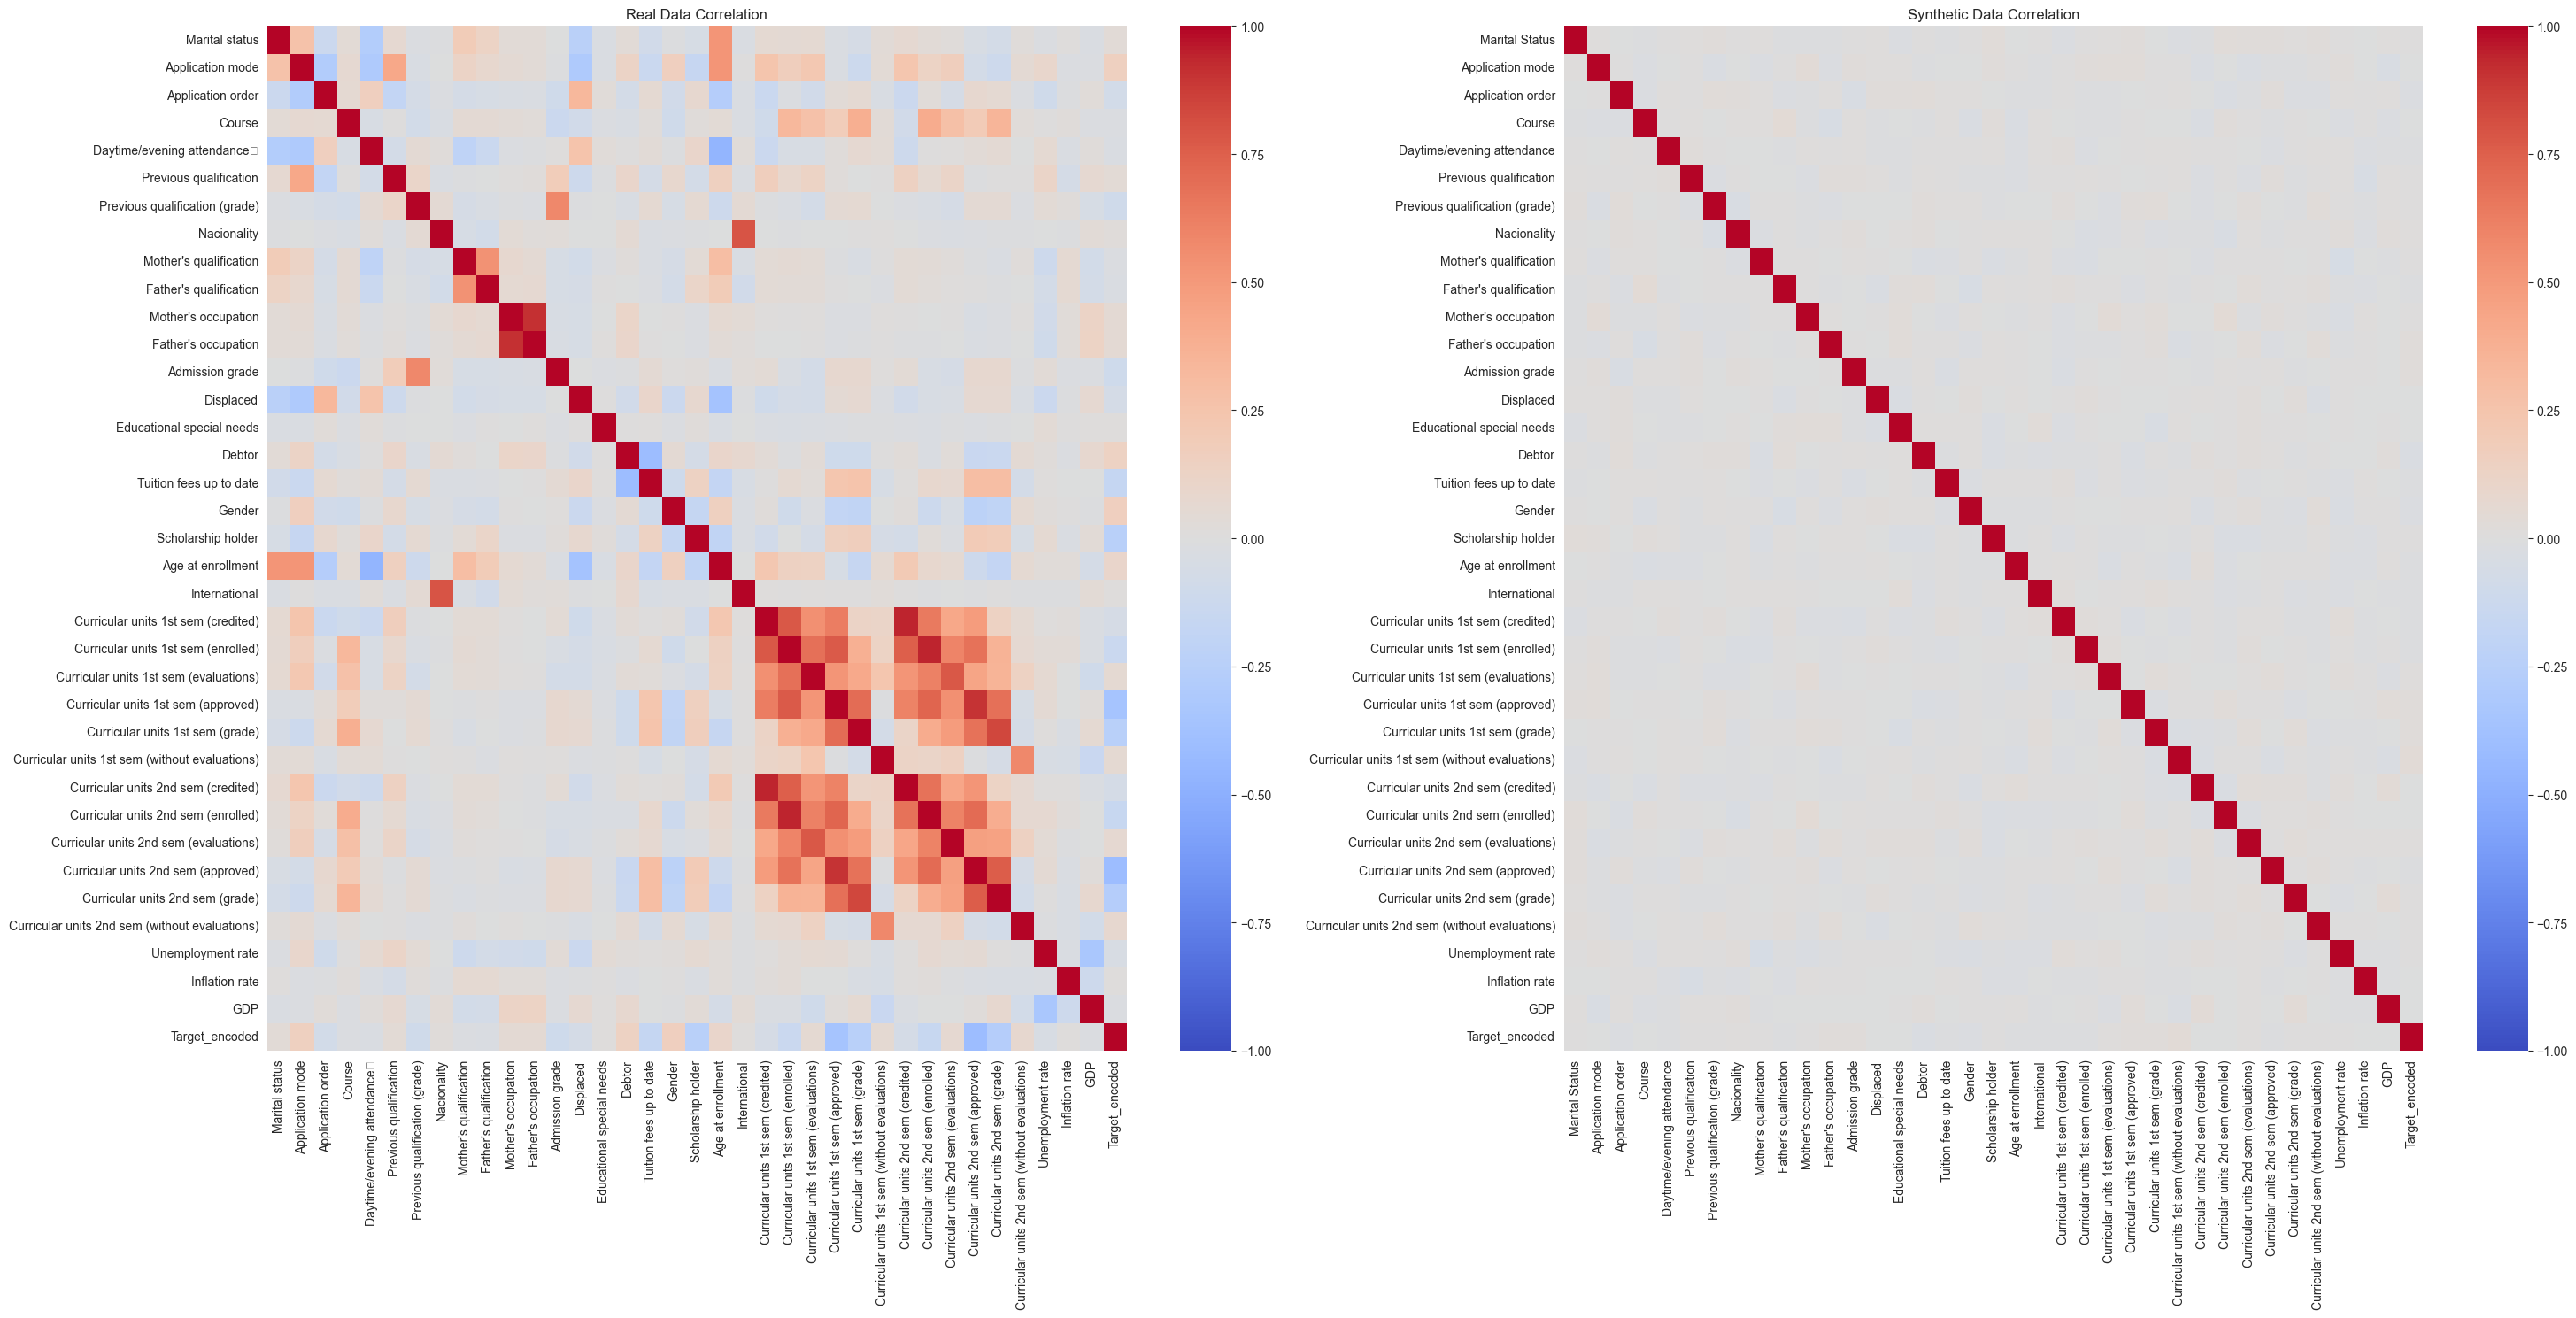

In [163]:
compare_correlation_matrices(df, df_gpt)

# Original VS Deepseek's datasets

E:\Research\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
E:\Research\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
E:\Research\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


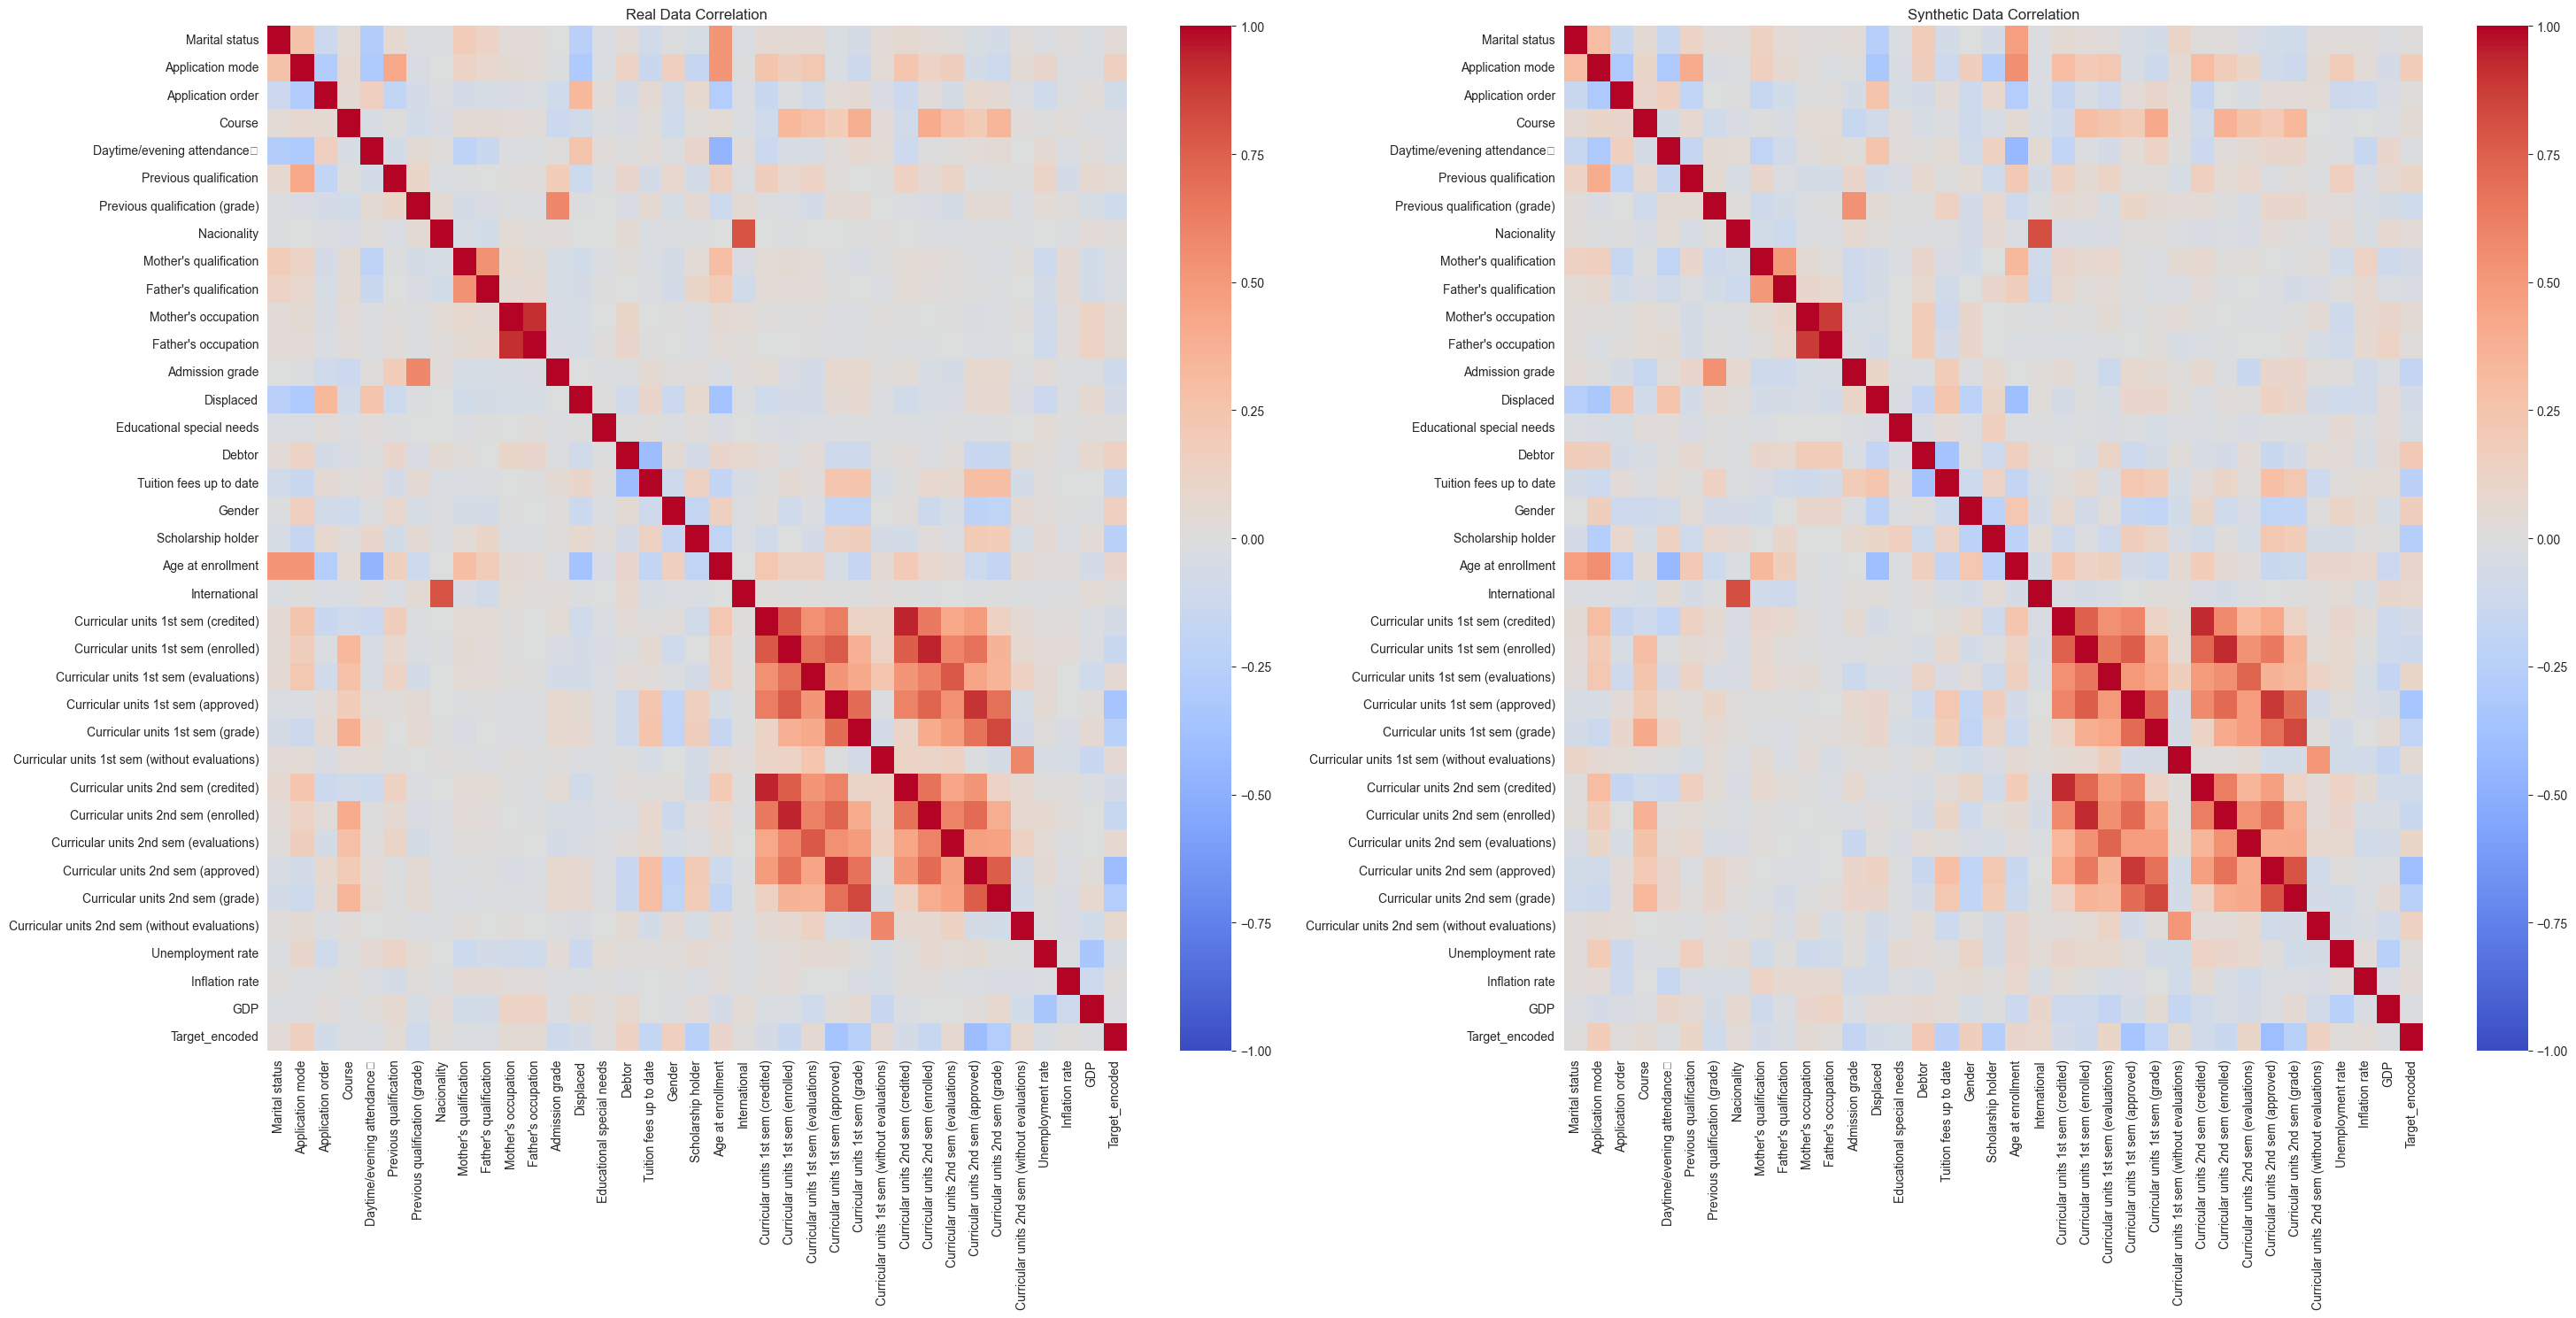

In [164]:
compare_correlation_matrices(df, df_deepseek)

# Original VS Copilot's datasets

E:\Research\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
E:\Research\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
E:\Research\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


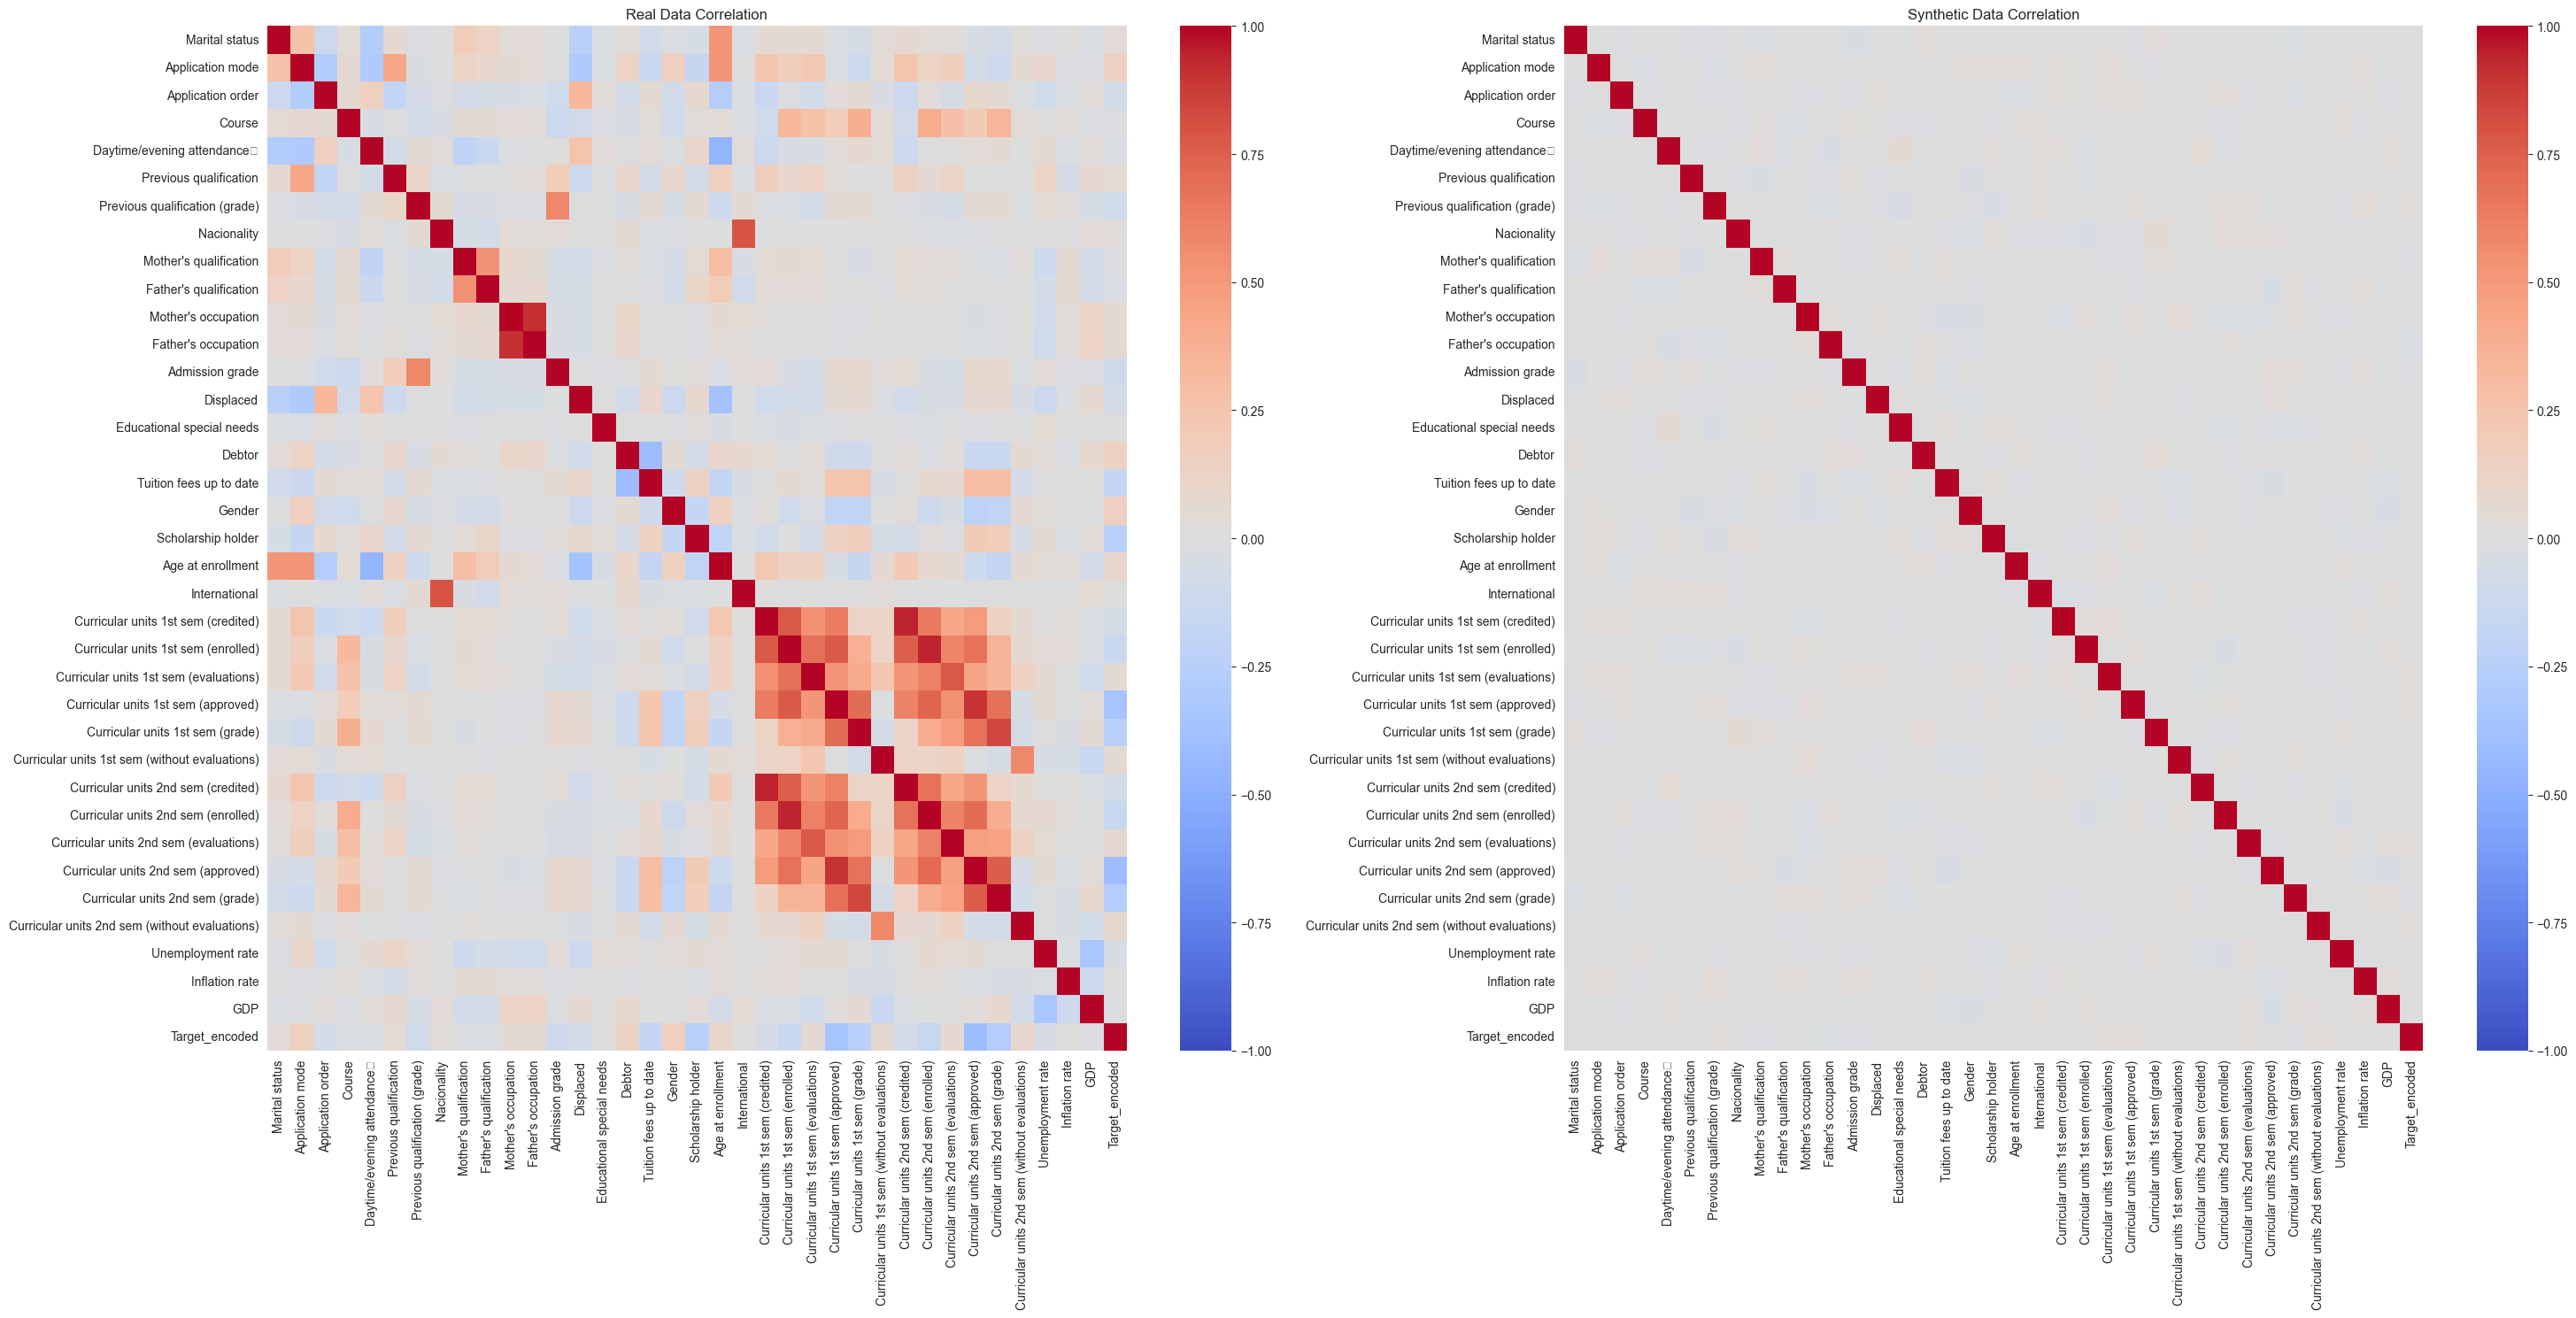

In [165]:
compare_correlation_matrices(df, df_copilot)

E:\Research\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
E:\Research\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
E:\Research\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


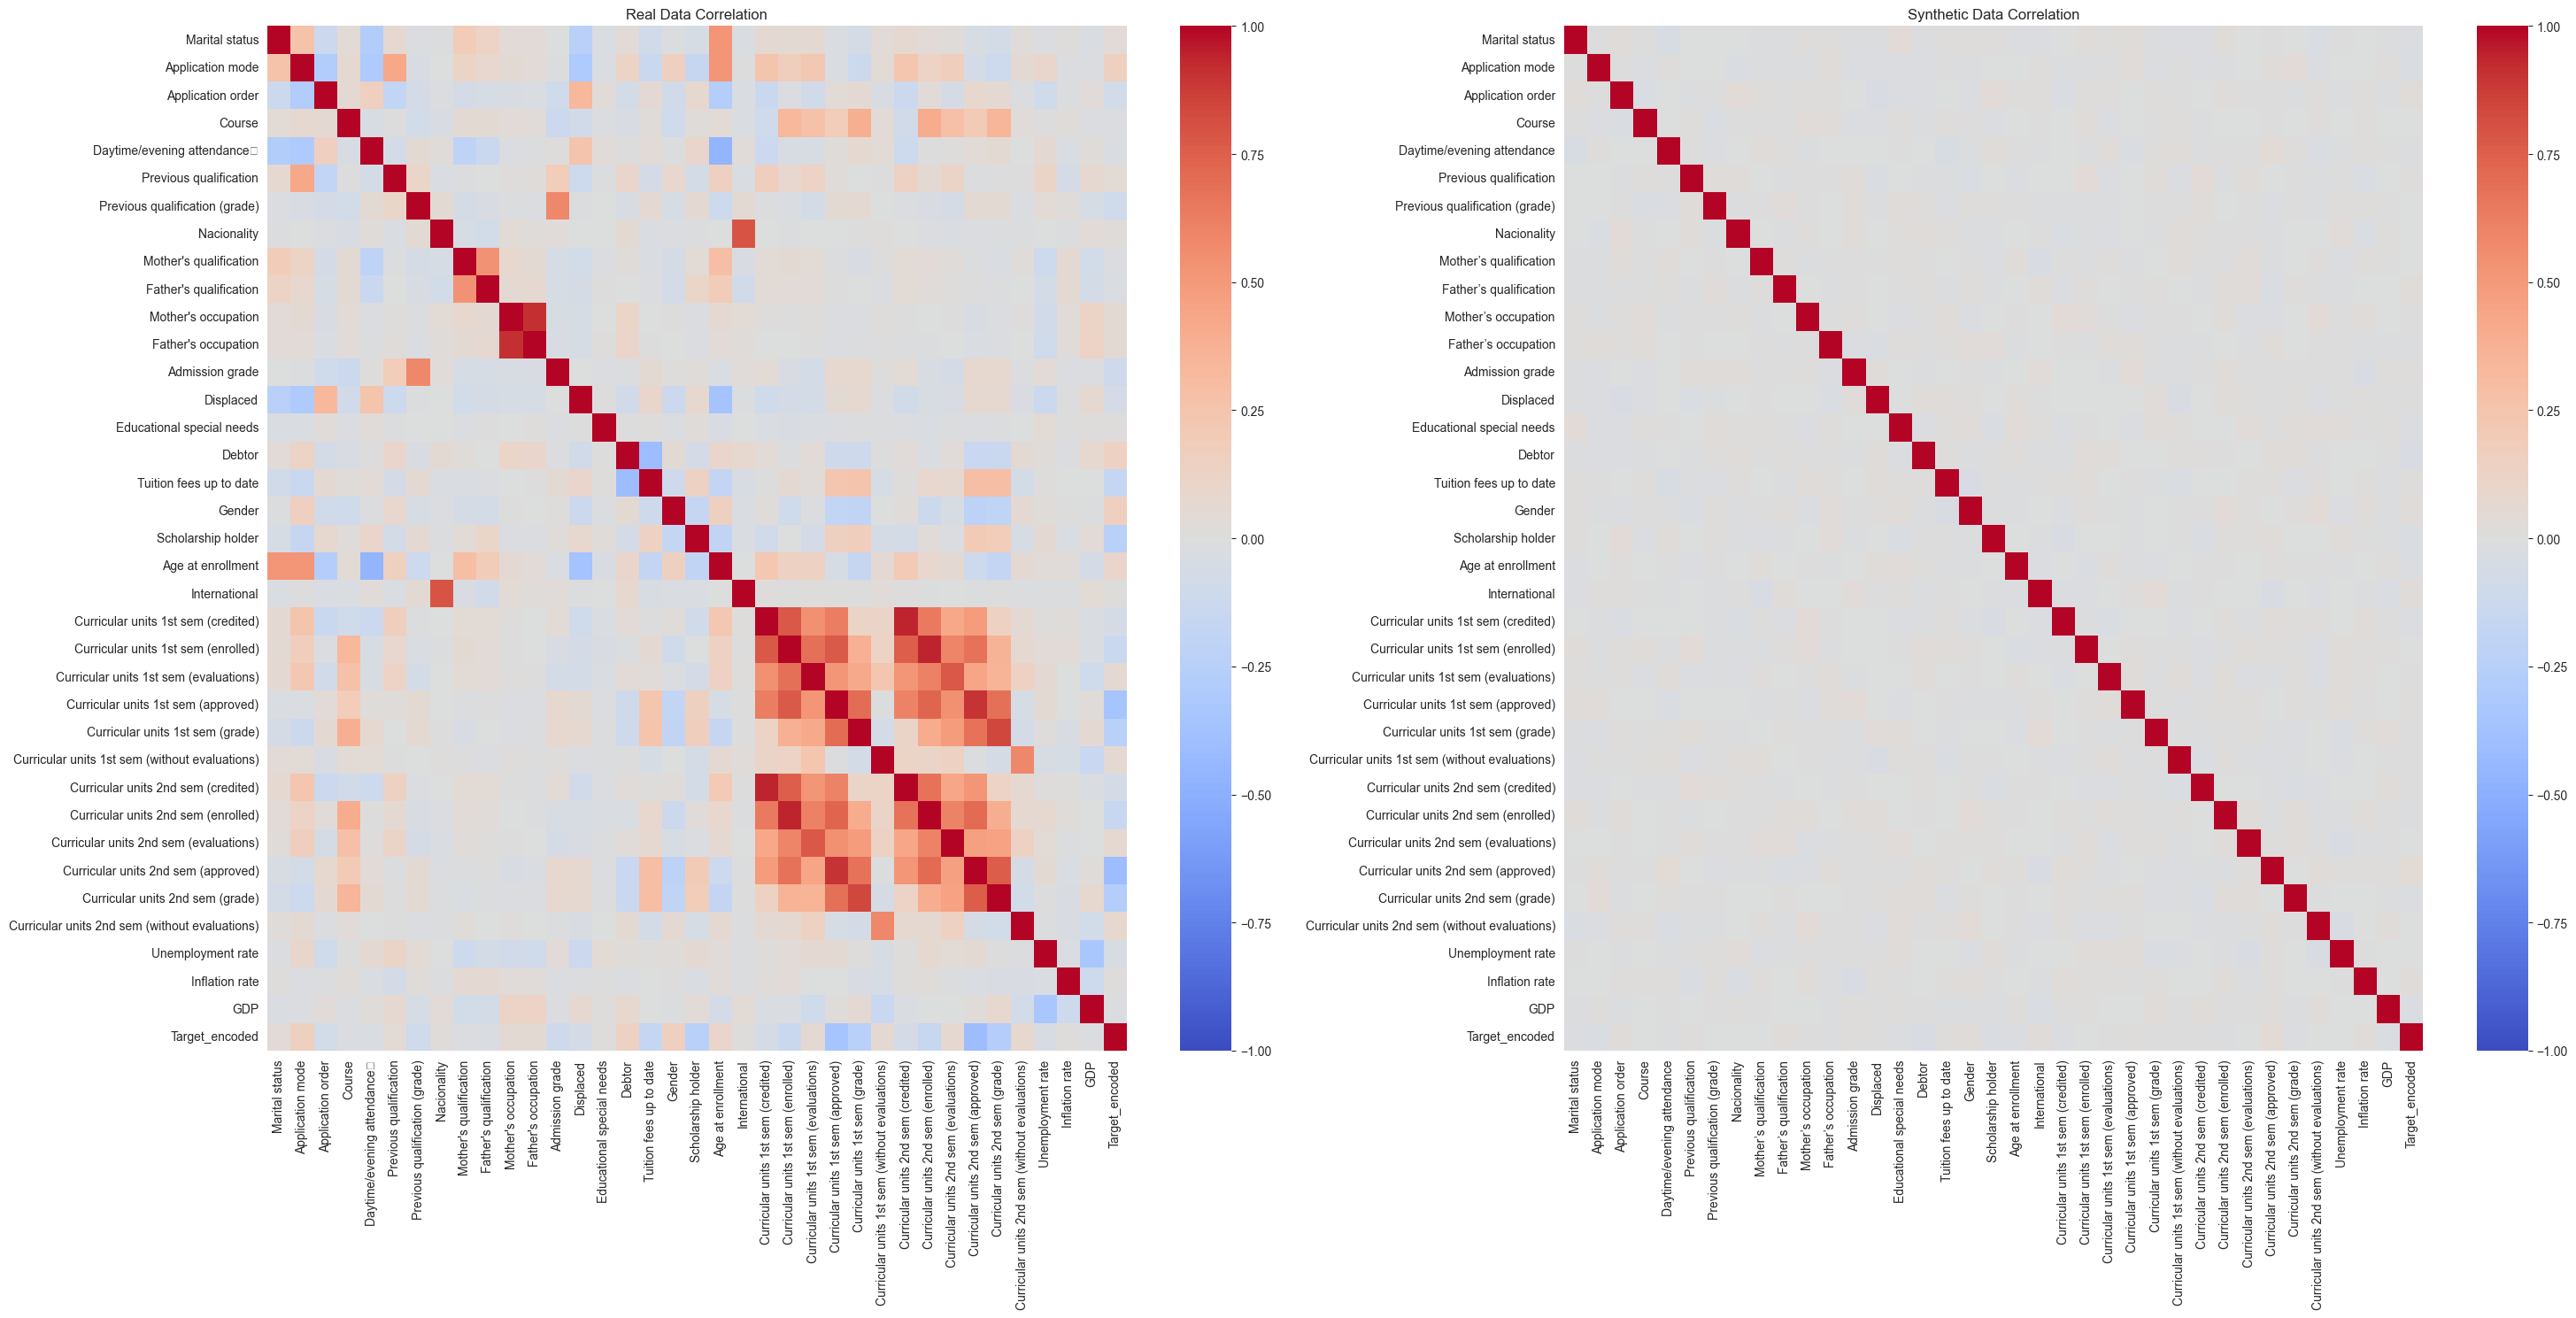

In [209]:
compare_correlation_matrices(df, mistral_instruct_df)

E:\Research\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
E:\Research\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
E:\Research\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


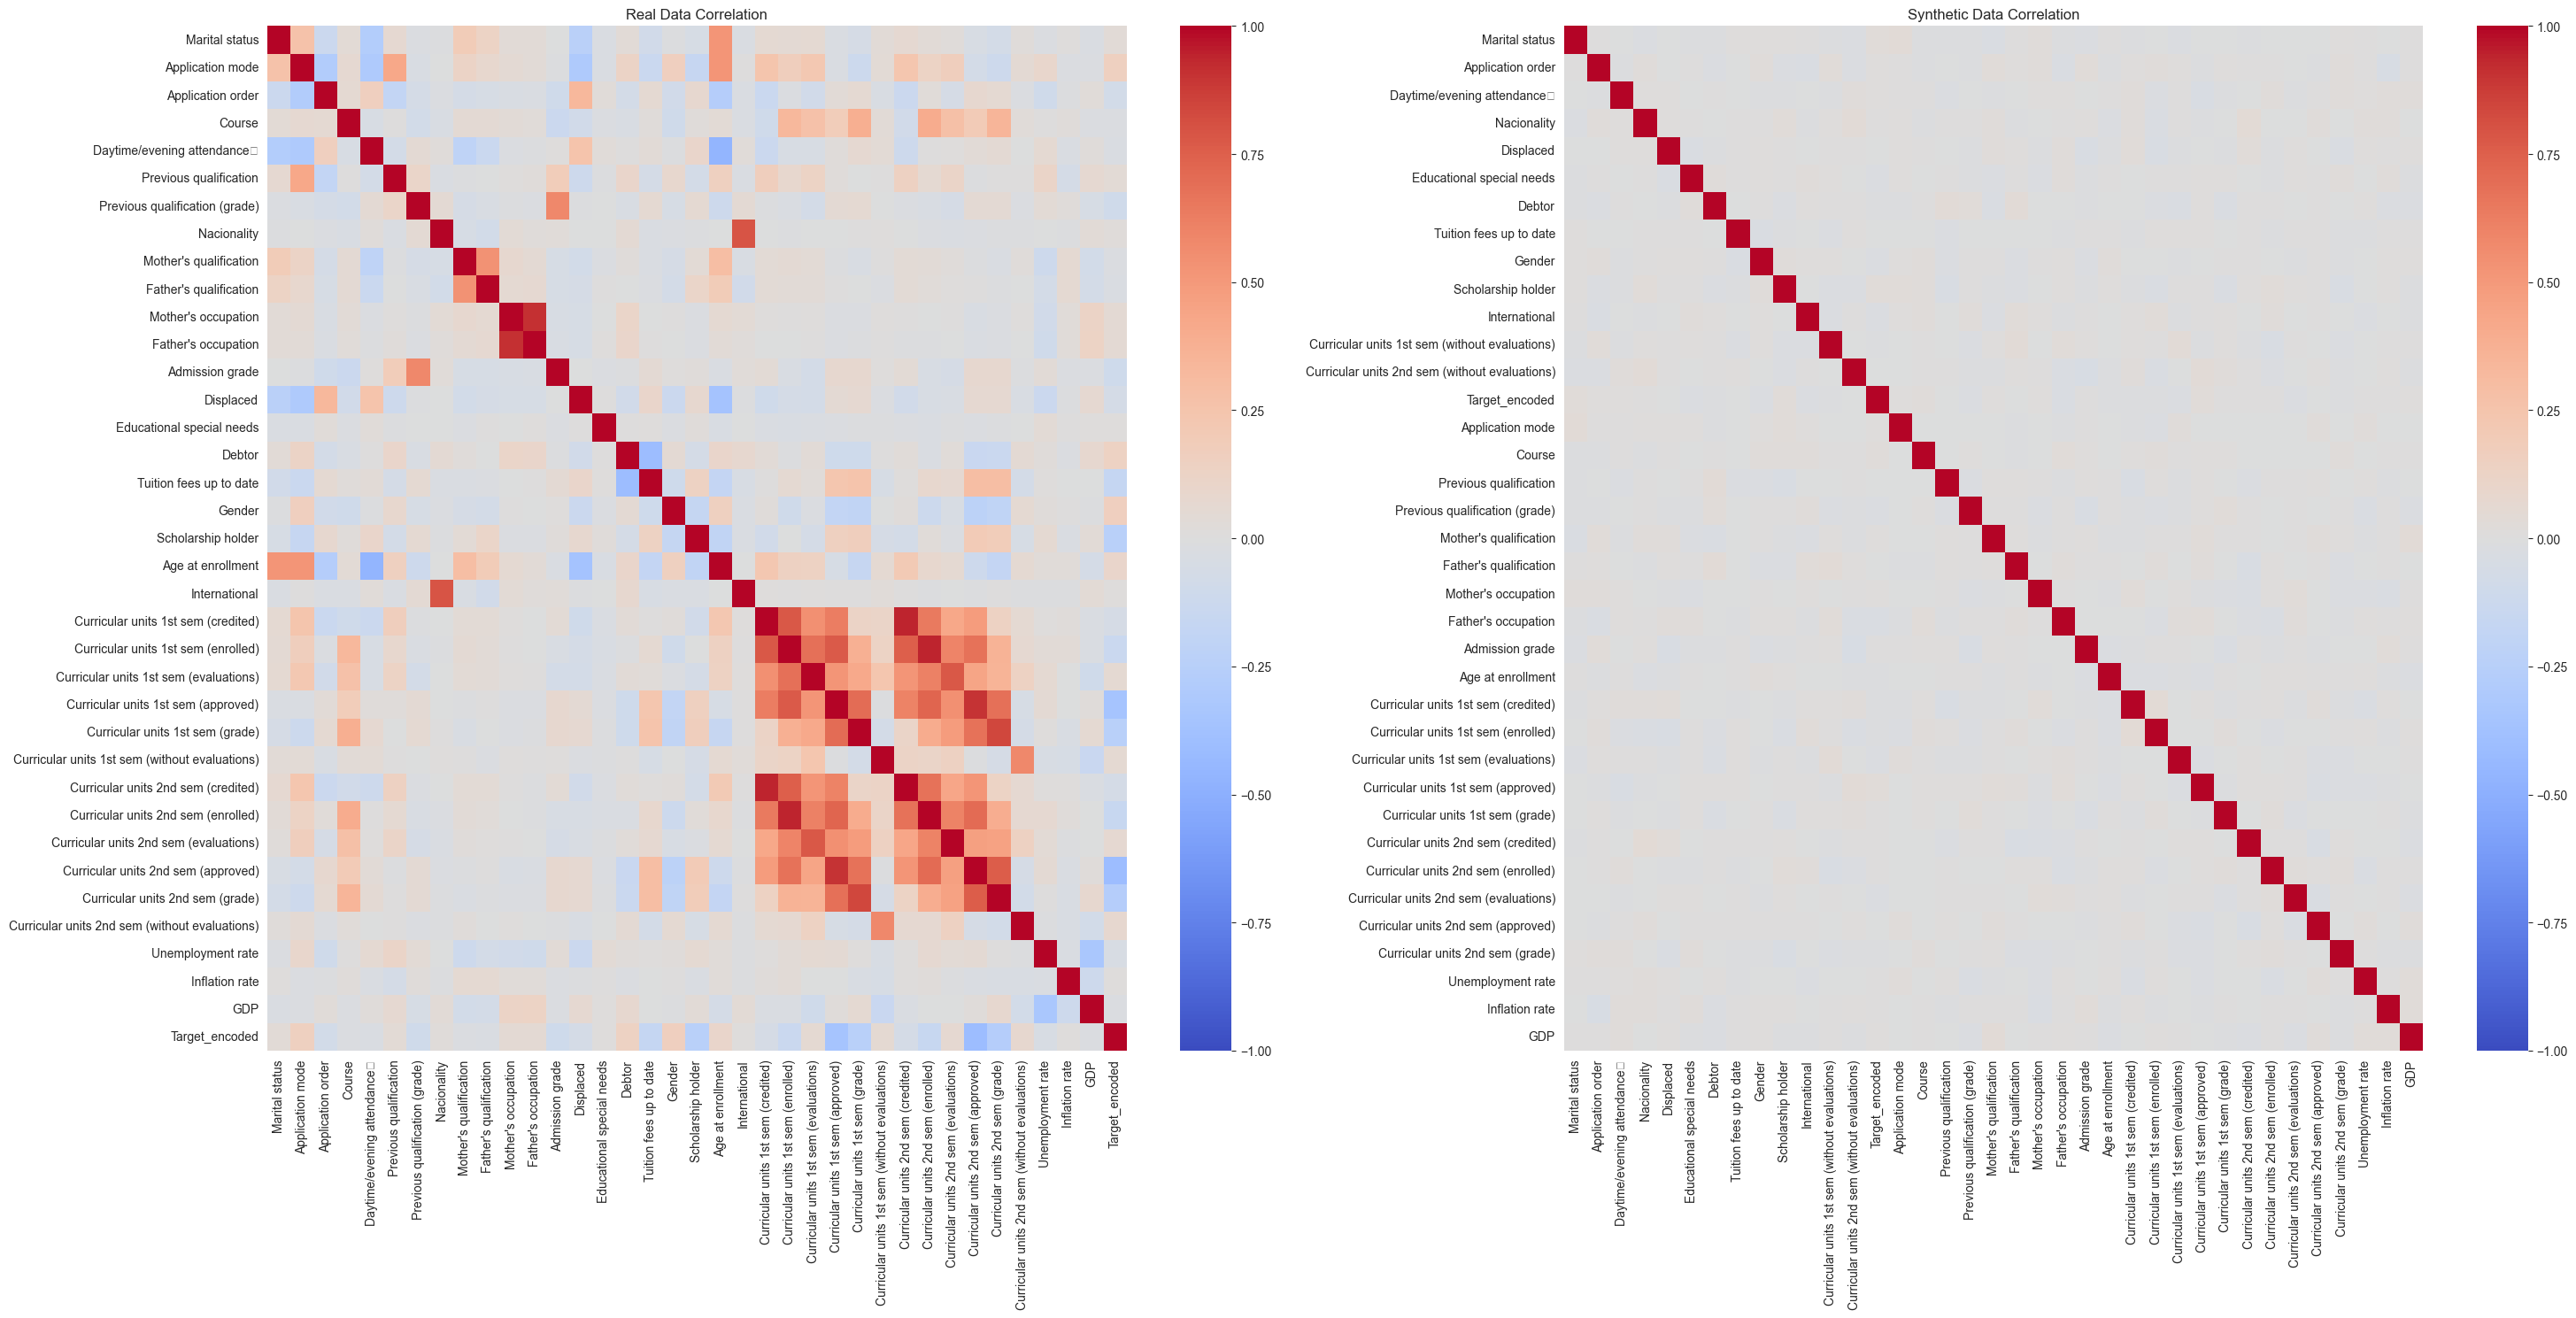

In [210]:
compare_correlation_matrices(df, llama3_df)